In [1]:
import pandas as pd, numpy as np
import ast, gc, re, math

In [2]:
import matplotlib, matplotlib.pyplot as plt
import seaborn as sns

In [3]:
PATH = '/Users/irenaradzevich/Documents/sergei_dev/final project/'

## Read the DATA and clean some DATA structure

In [4]:
data = pd.read_csv(PATH+'data.csv')
data.shape

(377185, 18)

In [5]:
data = data[~pd.isna(data.target)]      # drop records without target's value

In [6]:
# clean vectors names as PEP8 (not exact:)
data.columns = [i.replace('.','_') for i in data.columns]
data.columns = [i.replace(' ','_') for i in data.columns]
data.columns = [i.replace('-','_') for i in data.columns]

In [7]:
# drop records witch are not house actually - only buildable plan
data_copy = data.copy()
data_copy.street.fillna('no data', inplace=True)
data_copy[data_copy.street.str.contains('Buildable plan')]

,status,private_pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls_id,PrivatePool,MlsId,target
100,NaN,NaN,Single Family,Buildable plan: Coral Pine Lakes,4.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Jacksonville,"[{'rating': ['6/10', '4/10', '4/10'], 'data': ...","2,492",32218,4,FL,2,NaN,NaN,NaN,"$285,990"
292,NaN,NaN,Single Family,Buildable plan: Sabine Hidden Meadow - 40's,2,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Houston,"[{'rating': ['4/10', '4/10', '2/10'], 'data': ...","1,844",77044,4,TX,NaN,NaN,NaN,NaN,"$182,490"
342,New construction,NaN,Single Family,Buildable plan: Residence 1945 Catalina at Wes...,3.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Sacramento,"[{'rating': ['3/10', '3/10', 'NA'], 'data': {'...","1,945",95834,4,CA,2,NaN,NaN,NaN,"$423,990"
421,New construction,NaN,Single Family,Buildable plan: Tiberon High Point,3.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Seattle,"[{'rating': ['3/10', '6/10', '4/10'], 'data': ...","2,074",98126,4,WA,3,NaN,NaN,NaN,"$709,950"
555,NaN,NaN,Single Family,Buildable plan: The Westford Coronado,4.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,San Antonio,"[{'rating': ['8/10', '9/10', '9/10'], 'data': ...","3,143",78258,3,TX,2.0,NaN,NaN,NaN,"$412,900"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376713,NaN,NaN,Townhouse,Buildable plan: Camilla III Randal Walk,3.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Orlando,"[{'rating': ['7/10', '7/10', '6/10'], 'data': ...","1,602",32832,3,FL,NaN,NaN,NaN,NaN,"$274,390"
376869,New construction,NaN,Single Family,Buildable plan: The Woodland Savannah Highlands,2.5 ba,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Savannah,"[{'rating': ['5/10', '2/10'], 'data': {'Distan...","2,041 sqft",31407,3 bd,GA,NaN,NaN,NaN,NaN,"$238,900"
376953,New construction,NaN,Single Family,Buildable plan: Berkley Palmira Lakes,3 ba,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Fort Wayne,"[{'rating': ['6/10', '7/10', '9/10'], 'data': ...","2,562 sqft",46818,4 bd,IN,NaN,NaN,NaN,NaN,"$251,600"
377008,NaN,NaN,Single Family,Buildable plan: The Bowen Whisper Falls,3.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,San Antonio,"[{'rating': ['7/10', '5/10', '6/10'], 'data': ...","2,241",78252,3,TX,2.0,NaN,NaN,NaN,"$239,000"


In [8]:
data = data[~data_copy.street.str.contains('Buildable plan')] #2459

In [9]:
# drop records without address street
data = data[~pd.isna(data.street)]  # 2
# drop records with street data as "'Address Not Disclosed", "Undisclosed Address", "Address Not Available"
data = data[~data.street.str.contains('Address')]  #1668

# drop records of 'Land' type. It is not house
data = data[data.propertyType != 'Land'] #10938
data = data[data.propertyType != 'lot/land'] #20539

In [10]:
data.shape

(339034, 18)

In [11]:
# recognition DATA in vectors 'homeFacts' and 'schools' as dictionary (clean redundant brackets)
data.homeFacts = data.homeFacts.apply(lambda x: ast.literal_eval(x))
data.schools = data.schools.apply(lambda x: ast.literal_eval(x))

In [12]:
#data.sample(10).T

### Clearing target vector
Prices given in american format with dollar sign

In [13]:
def find_number(field: str, comma=True):
    """
    function to take only first numeric data from string
    :param field: string to find number
    :return: number (in string format)
    """

    # mask for search
    p = '[\d]+[.,\d]+|[\d]*[.][\d]+|[\d]+'

    # main cycle for searching
    if re.search(p, field) is not None:
        for catch in re.finditer(p, field):
            result = catch[0]
            if comma:
                if re.search(',', result) is not None:      # clearing commas in american format of numbers
                    result = result.replace(',', '')
            return result
    else: return 0

In [14]:
data.target = data.target.apply(find_number).apply(int)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339034 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        301755 non-null  object
 1   private_pool  4137 non-null    object
 2   propertyType  304818 non-null  object
 3   street        339034 non-null  object
 4   baths         261444 non-null  object
 5   homeFacts     339034 non-null  object
 6   fireplace     101297 non-null  object
 7   city          339025 non-null  object
 8   schools       339034 non-null  object
 9   sqft          315564 non-null  object
 10  zipcode       339034 non-null  object
 11  beds          277515 non-null  object
 12  state         339034 non-null  object
 13  stories       219901 non-null  object
 14  mls_id        24831 non-null   object
 15  PrivatePool   39574 non-null   object
 16  MlsId         277151 non-null  object
 17  target        339034 non-null  int64 
dtypes: int64(1), object(17)


In [16]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
import warnings
from sklearn import metrics
from sklearn.manifold import TSNE   # t-SNE – algorithm to downsize of matrix

from catboost import CatBoostRegressor
#from xgboost import XGBRegressor
#from lightgbm import LGBMRegressor
import category_encoders as ce
from tqdm.notebook import tqdm

In [17]:
def mape(y_true, y_pred):
    """
    function to calculate Mean Absolute Percentage Error
    """
    return np.mean(np.abs((y_pred-y_true)/y_true))*100

def smape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true))/(y_true+y_pred))*100

In [18]:
def mae(y_true, y_pred):
    """
    function to calculate Mean Absolute Error
    """
    return np.mean(np.abs(y_pred-y_true))

In [19]:
def mpl(alpha=0.5):
    """
    function to calculate Mean Pinball Loss
    :param y_true:
    :param y_pred:
    :param alpha:
    :return:
    """
    test_up = results.y_test > results.predict
    predict_up = results.y_test < results.predict
    a = results[test_up]['y_test'].sum() - results[test_up]['predict'].sum()
    b = results[predict_up]['predict'].sum() - results[predict_up]['y_test'].sum()
    mpl_value =  (alpha * a + (1 - alpha) * b) / results.shape[0]

    count_test_up = results[test_up]['y_test'].count() / results.shape[0]

    avg_under_test = a / results[test_up]['y_test'].count()
    avg_upper_test = b / results[predict_up]['y_test'].count()

    return mpl_value, 1-count_test_up, avg_under_test, avg_upper_test

In [20]:
results = pd.DataFrame()
def feature_imp(dataset, regressor, encoder, test_drop = True, target='price'):
    """
    function for checking feature importance on ML
    :param dataset: dataset for ML
    :param regressor: algorithm of ML
    :param encoder: encoder for categorical vectors
    :param test_drop: boolean flag whether need to separate test data from dataset
    :param target: name of target
    :return: list of features with weights descending, score of algorithm and MAPE score
    """
    global results

    # copy dataset useful if you need to drop some vectors from dataset
    dataset=dataset.copy()

    # checkin boolean flag to drop test data from dataset
    if test_drop:
        dataset = dataset[dataset.test == 0]

    # drop vector 'test'
    # dataset.drop(['test'], axis=1, inplace=True)

    # make variables x and y for ML model
    x, y = dataset.drop(target, axis=1), np.log(dataset[target])

    # encoding categorical vectors with encoder
    encoder.fit(x, y)
    X = encoder.transform(x)

    # split for validate and fit ML model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED)
    regressor.fit(X_train, y_train)

    # make dataframe with features importance
    importance = regressor.feature_importances_
    value = pd.DataFrame(data=importance, index=X.columns, columns=['importance'])
    print(value.importance.sort_values(ascending=False))

    # calculate ML model score
    score = regressor.score(X_test, y_test)

    y_true = np.exp(y_test)
    predict = np.exp(regressor.predict(X_test))

    if not results.empty:
        results.drop(columns=results.columns, inplace=True)
    results = X_test.copy()
    results['y_test'] = np.exp(y_test)
    results['predict'] = predict.astype('int64')

    # calculate metrics
    print(f'Score of regressor {score*100:0.2f}%')
    print(f"MAPE: {(mape(y_true, predict)):0.2f}%, SMAPE: {(smape(y_true, predict)):0.2f}%")
    print(f"MAE: {math.trunc(mae(y_true, predict))}$, ")
    # set quantile for pinball loss 0.01
    # it means we focused on over predicting prices and aimed to minimise it
    mpl_value, p, avg_under_test, avg_upper_test = mpl(alpha=0.01)
    print(f"Pinball Loss: {(mpl_value):0.2f}, over_pricing: {p:0.2f}%, mean over pricing: {avg_upper_test:0.0f}")
    print(f"                   under_pricing: {(1-p):0.2f}%, mean under pricing: {avg_under_test:0.0f}")

In [21]:
TARGET = 'target'
SEED = 42
list_to_drop = ['homeFacts', 'schools',
                 ]
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, target = TARGET, **parameters)

Learning rate set to 0.105812
0:	learn: 1.0110749	total: 90.3ms	remaining: 1m 30s
1:	learn: 0.9530434	total: 122ms	remaining: 1m
2:	learn: 0.9002962	total: 151ms	remaining: 50.1s
3:	learn: 0.8546388	total: 183ms	remaining: 45.4s
4:	learn: 0.8140242	total: 224ms	remaining: 44.7s
5:	learn: 0.7787881	total: 254ms	remaining: 42s
6:	learn: 0.7476198	total: 288ms	remaining: 40.8s
7:	learn: 0.7201870	total: 319ms	remaining: 39.6s
8:	learn: 0.6953513	total: 360ms	remaining: 39.7s
9:	learn: 0.6735647	total: 396ms	remaining: 39.2s
10:	learn: 0.6540334	total: 436ms	remaining: 39.2s
11:	learn: 0.6370005	total: 484ms	remaining: 39.8s
12:	learn: 0.6215462	total: 513ms	remaining: 39s
13:	learn: 0.6076585	total: 545ms	remaining: 38.4s
14:	learn: 0.5954543	total: 585ms	remaining: 38.4s
15:	learn: 0.5843835	total: 625ms	remaining: 38.4s
16:	learn: 0.5736208	total: 691ms	remaining: 40s
17:	learn: 0.5646947	total: 729ms	remaining: 39.8s
18:	learn: 0.5567410	total: 767ms	remaining: 39.6s
19:	learn: 0.54847

In [ ]:
# accuracy = 87.9, MAPE 158.48%, SMAPE 10.57%, MAE 187_695, PL 57411,  op 112904, up 263060  -  naive

In [32]:
print(f' min: {data.target.min()}, max: {data.target.max()}, ')
print(f' median: {data.target.median():0.0f}, avg: {data.target.mean():0.0f}')

 min: 1, max: 195000000, 
 median: 339300, avg: 676751


<AxesSubplot:xlabel='target', ylabel='Count'>

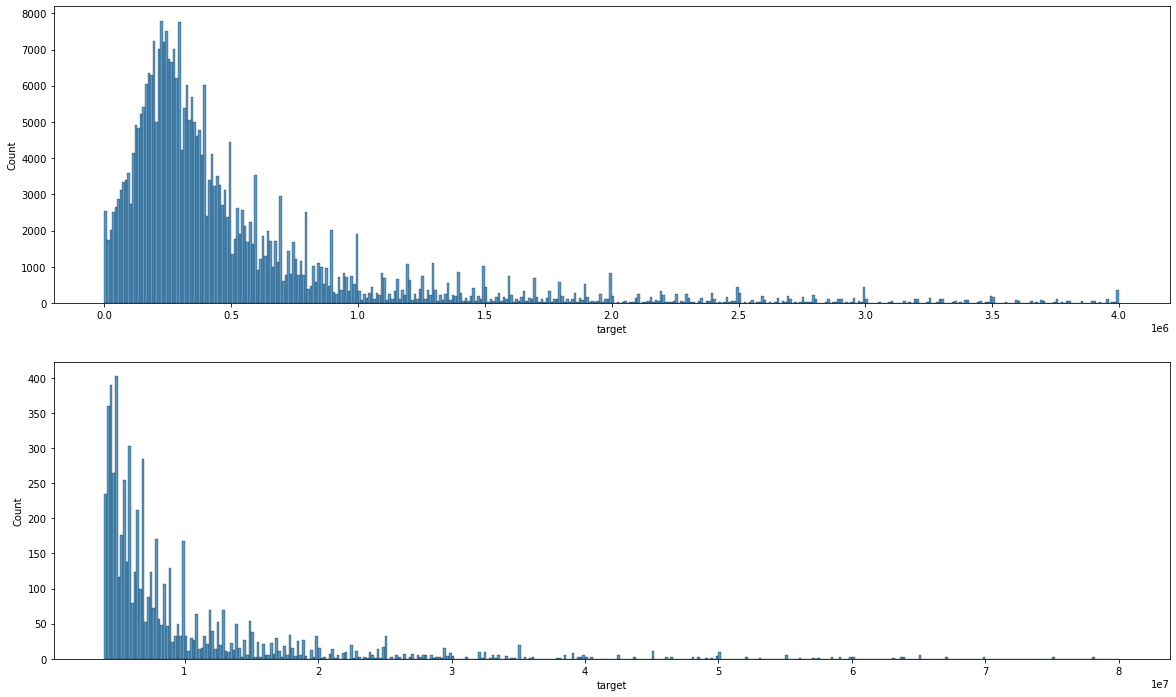

In [33]:
fig, ax = plt.subplots(figsize = (20, 12))
plt.subplot(211)
sns.histplot(data.target, binwidth=10000, binrange=(0,4000000))
plt.subplot(212)
sns.histplot(data.target, binwidth=200000, binrange=(4000000,80000000))

# Исследование целевой переменной

* Цена имеет очень широкий диапазон значений от 1 доллара до 195 млн.долларов. Несмотря на такой разброс - это не "качество", а его отсутствие. надо понимать, что цены на дома или недвижимость в целом в Америке (да и где бы то ни было) не могут иметь цену в 1, 10, 100, 1000 или даже 10 000 долларов. Есть подозрение, что цены менее 50 000 - подозрительны. Так что, предметом дальнейшего исследования целевой переменной будет оценка нижней границы отсеивания данных. В конечную модель эти данные подавать нельзя. Смысл таких цифр в графе "цена" - это просто заполнить его, как "обязательное" по условиям формы. А реальная цена собственником будет оперделятся при других обстоятельствах. Но эти обстоятельства нами не могут быть дифференцируемы.
* График демонстрирует условную "гладкость" распределения значений цены. Однако, надо учитывать специфику предмета "цена недвижимости". Несмотря на кажущийся огромным массив записей, несмотря на то, что некоторые значения формируются по строгой формуле *(цена)* * *(площадь)*, все равно, конечная цена будет сформирована субъективно. Мы и сейчас на графике наблюдаем пики прямо у "круглых" значений цены. Таким образом, учитывая, что это не массив данных о конечных сделках, а заявления продавцов о своих желаниях, вполне уместно было бы округлить цены до ближайших значений кратных десятичной степени в большую сторону. Вопрос стоит только в определении разряда округления. Скорее всего нужно рассмотреть схему окургления до "n-3 разряда".
* Учитывая широкий диапазон значений, понятно, что избежать логарифмирования целевой переменной в процессе применения ML или DL моделей не удастся.
* В базе данных менее 0.5% записей с объектами ценой более 10 млн.долларов. По всему видно, что это эксклюзивные предложения, которых вообще не так много. Соответственно и цены на них сформированы не сходя из стандартного списка параметров. Стоит рассмотреть механизм моделирования таких вариантов отдельно.
* В итоге работы следует определиться с практическим применением результатов работы модели. Вариантом такого применения может быть поиск предложений, цена на которые была бы ниже предсказанной. При этом у модели нужно предусмотреть настройку, чтобы ошибка "вверх", то есть, переоценка цены была бы минимальная, а чаще имело место недооценка.

In [34]:
def round_price(price):
    return np.around(price, -(len(str(price))-3))

n = [15670, 870998, 3298701, 22760983, 616143005]

for item in range(len(n)):
    print(n[item],' -> ', round_price(n[item]))

15670  ->  15700
870998  ->  871000
3298701  ->  3300000
22760983  ->  22800000
616143005  ->  616000000


In [35]:
# clean data from record of rental
data.status.fillna('nan', inplace=True)
data.status = data.status.apply(str.lower)

#filter records with realty for rent
rent = data[data.status.str.contains('rent')]
data = data[~data.status.str.contains('rent')]

## Vector 'private_pool'

In [36]:
pp = data.loc[:,['private_pool', 'PrivatePool']]
pp.fillna('na', inplace=True)
pp['compare'] = data.apply(lambda q: q.private_pool == q.PrivatePool, axis=1)

In [37]:
pp.groupby(['private_pool', 'PrivatePool'])['compare'].count()

private_pool  PrivatePool
Yes           na               4137
na            Yes             11353
              na             295008
              yes             28124
Name: compare, dtype: int64

In [38]:
pp_replace={'yes':1, 'na':0}

In [39]:
pp.private_pool = pp.private_pool.apply(str.lower).map(pp_replace)
pp.PrivatePool = pp.PrivatePool.apply(str.lower).map(pp_replace)
pp.groupby(['private_pool', 'PrivatePool'])['compare'].count()

private_pool  PrivatePool
0             0              295008
              1               39477
1             0                4137
Name: compare, dtype: int64

In [40]:
pp['pool'] = pp.private_pool + pp.PrivatePool
pp.groupby(['pool', 'private_pool', 'PrivatePool'])['compare'].count()

pool  private_pool  PrivatePool
0     0             0              295008
1     0             1               39477
      1             0                4137
Name: compare, dtype: int64

In [41]:
data.private_pool = pp.pool
data.drop('PrivatePool', inplace=True, axis=1)
del pp
gc.collect()

530

In [42]:
TARGET = 'target'
SEED = 42
list_to_drop = ['homeFacts', 'schools',
                ]
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, target=TARGET, **parameters)

Learning rate set to 0.105789
0:	learn: 0.9971038	total: 49.2ms	remaining: 49.1s
1:	learn: 0.9382979	total: 82.4ms	remaining: 41.1s
2:	learn: 0.8857978	total: 109ms	remaining: 36.3s
3:	learn: 0.8391889	total: 139ms	remaining: 34.5s
4:	learn: 0.7985070	total: 173ms	remaining: 34.4s
5:	learn: 0.7634885	total: 216ms	remaining: 35.7s
6:	learn: 0.7318572	total: 243ms	remaining: 34.5s
7:	learn: 0.7052197	total: 282ms	remaining: 35s
8:	learn: 0.6808821	total: 333ms	remaining: 36.6s
9:	learn: 0.6581560	total: 376ms	remaining: 37.2s
10:	learn: 0.6388978	total: 407ms	remaining: 36.6s
11:	learn: 0.6223671	total: 436ms	remaining: 35.9s
12:	learn: 0.6075985	total: 480ms	remaining: 36.4s
13:	learn: 0.5941435	total: 514ms	remaining: 36.2s
14:	learn: 0.5824174	total: 556ms	remaining: 36.5s
15:	learn: 0.5708823	total: 584ms	remaining: 35.9s
16:	learn: 0.5617285	total: 612ms	remaining: 35.4s
17:	learn: 0.5533874	total: 643ms	remaining: 35.1s
18:	learn: 0.5458539	total: 688ms	remaining: 35.5s
19:	learn: 

In [27]:
# accuracy = 87.9, MAPE 158.48%, SMAPE 10.57%, MAE 187_695, PL 57411,  op 112904, up 263060  -  naive
# ----
# accuracy = 87.38, MAPE 187.55%, SMAPE 10.52%, MAE 184_270, PL 58034,  op 113738, up 255976  -  pool clean

#### homeFacts
extract data from vector 'homeFacts' to new vectors

In [43]:
def home_facts(item):
    item = item['atAGlanceFacts']
    values = []
    for i in item:
        if i:
            values.append(i['factValue'])
        else:
            ''
    build, renovate, heating, cooling, parking, lotsize, price_sqft = values
    return build, renovate, heating, cooling, parking, lotsize, price_sqft

In [44]:
data['build'] = data.homeFacts.apply(lambda q: home_facts(q)[0])
data['renovate'] = data.homeFacts.apply(lambda q: home_facts(q)[1])
data['heating'] = data.homeFacts.apply(lambda q: home_facts(q)[2])
data['cooling'] = data.homeFacts.apply(lambda q: home_facts(q)[3])
data['parking'] = data.homeFacts.apply(lambda q: home_facts(q)[4])
data['lotsize'] = data.homeFacts.apply(lambda q: home_facts(q)[5])
data['price_sqft'] = data.homeFacts.apply(lambda q: home_facts(q)[6])

In [33]:
#data[['build', 'renovate', 'heating', 'cooling', 'parking', 'lotsize', 'price_sqft']] = data.homeFacts.apply(list(home_facts))

# Extracting numeric data
* lot size
* sqft price
* bathes
* beds

#### 'lotsize' and 'sqft'

In [45]:
data[['sqft', 'lotsize']]

,sqft,lotsize
0,2900,None
1,"1,947 sqft",5828 sqft
2,"3,000 sqft","8,626 sqft"
3,"6,457 sqft","8,220 sqft"
5,897 sqft,680 sqft
...,...,...
377180,"4,017","8,500 sqft"
377181,"2,000 sqft",
377182,"1,152 sqft","1,600 sqft"
377183,NaN,None


In [46]:
square = data[['sqft', 'lotsize']].copy()
square.fillna('nan', inplace=True)

In [47]:
def literal_text(item):
    """
    function take only literal part of 'item' value
    :param item: original value
    :return: text from value, if no literal - 'nan'
    """
    pattern = '[0-9,]+'
    result = re.sub(pattern, '', item)
    if result:
        return result
    else:
        return 'nan'

In [48]:
# make vectors with literal parts of vectors 'sqft' and 'lotsize'
square['sqft_text'] = square.sqft.apply(literal_text).apply(str.lower)
square['lot_text'] = square.lotsize.apply(literal_text).apply(str.lower)

In [49]:
def square_clearing(value, literal):
    """
    function is clearing data in vectors 'sqft' and 'lotsize', extract numeric value and transform acres to sqft
    :param value: original value in vector
    :param literal: literal part of original value
    :return: value of square feets in numeric format
    """
    arc, sqft = False, False
    try:
        if re.search('acr', literal):
            arc = True
    except: pass

    try:
        if re.search('sq', literal):
            sqft = True
    except: pass

    value = float(find_number(value))

    if arc:
        value = np.around(value * 43560)        # 1 acre = 43560 sq.feets

    return value

In [50]:
square['sqft_value']=square.apply(lambda q: square_clearing(q.sqft, q.sqft_text), axis=1)
square['lot_value']=square.apply(lambda q: square_clearing(q.lotsize, q.lot_text), axis=1)

In [51]:
data.loc[:,['sqft_value', 'lot_value']] = square.loc[:,['sqft_value', 'lot_value']]
del square
gc.collect()

75

In [52]:
# records with the same address, square and target - is the same, even if they have different baths number...,
# so - drop thees records
data.drop_duplicates(subset=['street', 'city', 'sqft_value', 'target'], inplace=True)

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312603 entries, 0 to 377184
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        312603 non-null  object 
 1   private_pool  312603 non-null  int64  
 2   propertyType  278411 non-null  object 
 3   street        312603 non-null  object 
 4   baths         236474 non-null  object 
 5   homeFacts     312603 non-null  object 
 6   fireplace     90449 non-null   object 
 7   city          312594 non-null  object 
 8   schools       312603 non-null  object 
 9   sqft          289255 non-null  object 
 10  zipcode       312603 non-null  object 
 11  beds          251365 non-null  object 
 12  state         312603 non-null  object 
 13  stories       197971 non-null  object 
 14  mls_id        22596 non-null   object 
 15  MlsId         254198 non-null  object 
 16  target        312603 non-null  int64  
 17  build         309068 non-null  object 
 18  reno

In [54]:
TARGET, SEED = 'target', 42
list_to_drop = ['homeFacts', 'schools',
                ]
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, target=TARGET, **parameters)

Learning rate set to 0.104294
0:	learn: 0.9963863	total: 46.4ms	remaining: 46.4s
1:	learn: 0.9310665	total: 83.6ms	remaining: 41.7s
2:	learn: 0.8716103	total: 116ms	remaining: 38.7s
3:	learn: 0.8198486	total: 150ms	remaining: 37.3s
4:	learn: 0.7718504	total: 193ms	remaining: 38.5s
5:	learn: 0.7288381	total: 238ms	remaining: 39.4s
6:	learn: 0.6914096	total: 284ms	remaining: 40.3s
7:	learn: 0.6586410	total: 329ms	remaining: 40.8s
8:	learn: 0.6287416	total: 378ms	remaining: 41.6s
9:	learn: 0.6021445	total: 426ms	remaining: 42.2s
10:	learn: 0.5786067	total: 462ms	remaining: 41.5s
11:	learn: 0.5576663	total: 496ms	remaining: 40.8s
12:	learn: 0.5384388	total: 534ms	remaining: 40.6s
13:	learn: 0.5211036	total: 573ms	remaining: 40.4s
14:	learn: 0.5050895	total: 624ms	remaining: 41s
15:	learn: 0.4908643	total: 656ms	remaining: 40.3s
16:	learn: 0.4780562	total: 682ms	remaining: 39.4s
17:	learn: 0.4662487	total: 715ms	remaining: 39s
18:	learn: 0.4560820	total: 756ms	remaining: 39s
19:	learn: 0.44

In [125]:
# Target, privet_pool, homeFacts extract, square clearing
# accuracy = 93.63, MAPE 187.47%, SMAPE 5.18%, MAE 123_825, PL 42619,  op 83060, up 165978

#### 'price_sqft' and 'sqft_value'

 + Вектор "price_sqft" загрязнен знаком доллара и текстом, раскрывающим суть данных - это стоимость одного квадратного фута дома (квартиры). Для модели выделим числовое значение из текста.
 + Так же есть записи, где отстутствует часть информации: или нет цены за фут, или нет площади. Через формулу можем восстановить эти данные

In [39]:
data.price_sqft

0              $144
1         $159/sqft
2         $965/sqft
3         $371/sqft
4              None
            ...    
377180         $311
377181    $337/sqft
377182    $458/sqft
377183         None
377184         $140
Name: price_sqft, Length: 374292, dtype: object

In [55]:
price_lot = data[['target', 'price_sqft', 'sqft_value']].copy()
price_lot.fillna('0', inplace=True)
price_lot['price_value'] = price_lot.price_sqft.apply(find_number).apply(int)

# recalculating data
for item in tqdm(price_lot.index):
    record = price_lot.loc[item]
    target, sqft, price = record.target, record.sqft_value, record.price_value
    if sqft and not price:
        price = target / sqft
        price_lot.loc[item, 'price_value']=price
    if not sqft and price:
        sqft = target / price
        price_lot.loc[item, 'sqft_value']=sqft

  0%|          | 0/312603 [00:00<?, ?it/s]

In [56]:
data[['sqft_value', 'price_value']] = price_lot[['sqft_value', 'price_value']]
del price_lot
gc.collect()

60

In [65]:
TARGET, SEED = 'target', 42
list_to_drop = ['homeFacts', 'schools',
                ]
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, target=TARGET, **parameters)

Learning rate set to 0.104294
0:	learn: 0.9907699	total: 31.3ms	remaining: 31.3s
1:	learn: 0.9218515	total: 53ms	remaining: 26.4s
2:	learn: 0.8604625	total: 76.4ms	remaining: 25.4s
3:	learn: 0.8045367	total: 100ms	remaining: 24.9s
4:	learn: 0.7554734	total: 123ms	remaining: 24.6s
5:	learn: 0.7107856	total: 151ms	remaining: 25s
6:	learn: 0.6705881	total: 179ms	remaining: 25.4s
7:	learn: 0.6335277	total: 210ms	remaining: 26.1s
8:	learn: 0.6007356	total: 239ms	remaining: 26.3s
9:	learn: 0.5699826	total: 268ms	remaining: 26.5s
10:	learn: 0.5440150	total: 302ms	remaining: 27.2s
11:	learn: 0.5196715	total: 337ms	remaining: 27.8s
12:	learn: 0.4978453	total: 373ms	remaining: 28.3s
13:	learn: 0.4775373	total: 398ms	remaining: 28s
14:	learn: 0.4607508	total: 432ms	remaining: 28.4s
15:	learn: 0.4449827	total: 467ms	remaining: 28.7s
16:	learn: 0.4304658	total: 501ms	remaining: 29s
17:	learn: 0.4172057	total: 529ms	remaining: 28.9s
18:	learn: 0.4063126	total: 571ms	remaining: 29.5s
19:	learn: 0.396

In [ ]:
# (previous) accuracy = 93.63, MAPE 187.47%, SMAPE 5.18%, MAE 123_825, PL 42619,  op 83060, up 165978  square
#            accuracy = 94.94, MAPE 199.95%, SMAPE 3.10%, MAE  82_087, PL 26079,  op 51551, up 112620

#### baths

In [128]:
def vocabulary(vector, dataframe, keys=False, sep=','):
    """
    function to make vocabulary from vector
    :param vector: vector to analyse
    :param dataframe: dataframe to analyse
    :param keys: bool flag to make dictionary or dataframe. Default value = True => dictionary
    :param sep: text separator, Default value = ','
    :return: dictionary of key as literals and values as frequency in vector or dataframe from result dictionary
    """
    from collections import Counter
    vocab_set = []
    for record in dataframe[vector]:
        try:
            for item in str(record).split(sep):
                if (sep!=' ')&(item[0]==' '):
                    vocab_set.append(item[1:])
                else:
                    vocab_set.append(item)
        except:
            vocab_set.append(str(record))
    if keys:
        result = Counter(vocab_set)
    else:
        result = pd.DataFrame.from_dict(Counter(vocab_set),
                                        orient='index',
                                        columns=['count']).sort_values(by='count' , ascending=False)
    return result

In [60]:
# filling NaN with string value 'nan' and turn texts to lower case
data.baths.fillna('nan', inplace=True)
data.baths = data.baths.str.lower()

In [61]:
# extract values from vector 'bath'
baths = data[['sqft_value', 'lot_value', 'baths', 'beds']].copy()
baths['baths_value'] = baths.baths.apply(find_number).apply(float)
# some data seems to have mistaken format. For example 1,500 - it is 1.5. So normalise this.
baths['baths_value'] = baths.baths_value.apply(lambda q: q if q<250 else q/1000)
# as for normal understanding 2.5 baths means 2 full baths and 1 - half bath or
# 2.2 - 2 full baths and 2 half baths.
# So - recalculate it to just quantity (actually - round to the ceil)
baths['baths_value'] = baths.baths_value.apply(math.ceil)

In [62]:
# some records don't have values of baths. But we can recalculate it
# from square of house (vector 'sqft_values').
# If 'sqft_value' is empty, we try to use vector 'lot_value'.
# And make ceil of number of baths as 50.
for item in tqdm(baths.index):
    record = baths.loc[item,:]
    sqft, lot, value = record.sqft_value, record.lot_value, record.baths_value
    if not value:
        if sqft:
            value = min(50, math.ceil(sqft/1000))
        else:
            value = min(50, math.ceil(lot/1000))

        baths.loc[item, 'baths_value'] = value

  0%|          | 0/312603 [00:00<?, ?it/s]

In [63]:
baths.groupby('baths_value')['sqft_value'].agg(['min', 'mean', 'median', 'max', 'count'])

,min,mean,median,max,count
baths_value,,,,,
0,0.0,0.000000,0.0,0.0,11295
1,0.0,1080.493629,840.0,651914.0,32270
2,0.0,8244.112981,1458.0,795979430.0,124166
3,0.0,2434.653900,2239.0,2807917.0,83884
4,0.0,3224.428702,3114.0,678055.0,32163
5,0.0,4075.965805,4110.5,220000.0,11292
6,0.0,4976.140516,5084.0,550905.0,5173
7,0.0,5271.783044,6044.0,120073.0,2741
8,0.0,4958.474423,6126.0,26638.0,1770


In [64]:
data['baths_value'] = baths.baths_value

In [66]:
TARGET, SEED = 'target', 42
list_to_drop = ['homeFacts', 'schools',
                ]
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, target=TARGET, **parameters)

Learning rate set to 0.104294
0:	learn: 0.9907699	total: 25.7ms	remaining: 25.7s
1:	learn: 0.9218515	total: 47.9ms	remaining: 23.9s
2:	learn: 0.8604625	total: 69.4ms	remaining: 23.1s
3:	learn: 0.8045367	total: 90.3ms	remaining: 22.5s
4:	learn: 0.7554734	total: 113ms	remaining: 22.4s
5:	learn: 0.7107856	total: 136ms	remaining: 22.5s
6:	learn: 0.6705881	total: 159ms	remaining: 22.5s
7:	learn: 0.6335277	total: 183ms	remaining: 22.7s
8:	learn: 0.6007356	total: 211ms	remaining: 23.3s
9:	learn: 0.5699826	total: 236ms	remaining: 23.3s
10:	learn: 0.5440150	total: 267ms	remaining: 24s
11:	learn: 0.5196715	total: 296ms	remaining: 24.4s
12:	learn: 0.4978453	total: 323ms	remaining: 24.5s
13:	learn: 0.4775373	total: 369ms	remaining: 26s
14:	learn: 0.4607508	total: 411ms	remaining: 27s
15:	learn: 0.4449827	total: 442ms	remaining: 27.2s
16:	learn: 0.4304658	total: 472ms	remaining: 27.3s
17:	learn: 0.4172057	total: 498ms	remaining: 27.1s
18:	learn: 0.4063126	total: 531ms	remaining: 27.4s
19:	learn: 0.

In [52]:
# accuracy = 94.79, MAPE 299.47%, SMAPE 4.17%, MAE 83_259, PL 25172,  op 49509, up 117235

In [53]:
data[(data.sqft_value!=0)|(data.lot_value!=0)]

,status,private_pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,...,renovate,heating,cooling,parking,lotsize,price_sqft,sqft_value,lot_value,price_value,baths_value
0,active,0,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,...,,"Central A/C, Heat Pump",,,None,$144,2900.0,0.0,144.0,4
1,for sale,0,single-family home,12911 E Heroy Ave,3 baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",...,,,,,5828 sqft,$159/sqft,1947.0,5828.0,159.0,3
2,for sale,1,single-family home,2005 Westridge Rd,2 baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",...,1967,Forced Air,Central,Attached Garage,"8,626 sqft",$965/sqft,3000.0,8626.0,965.0,2
3,for sale,0,single-family home,4311 Livingston Ave,8 baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",...,2006,Forced Air,Central,Detached Garage,"8,220 sqft",$371/sqft,6457.0,8220.0,371.0,8
4,for sale,0,lot/land,1524 Kiscoe St,nan,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,...,,,,,"10,019 sqft",None,0.0,10019.0,0.0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377179,for sale,0,Condo,2238 11th St NW APT 2,3,"{'atAGlanceFacts': [{'factValue': '2010', 'fac...",NaN,Washington,"[{'rating': ['3/10', '3/10'], 'data': {'Distan...","1,417",...,None,Forced air,Central,1 space,None,$564,1417.0,0.0,564.0,3
377180,nan,1,Single Family,20800 NE 23rd Ave,6.0,"{'atAGlanceFacts': [{'factValue': '1990', 'fac...",NaN,Miami,"[{'rating': ['10/10', '5/10'], 'data': {'Dista...","4,017",...,1990,Other,Central,2 spaces,"8,500 sqft",$311,4017.0,8500.0,311.0,6
377181,for sale,0,condo,3530 N Lake Shore Dr #4B,3 baths,"{'atAGlanceFacts': [{'factValue': '1924', 'fac...",NaN,Chicago,"[{'rating': ['1/10', '5/10', '7/10'], 'data': ...","2,000 sqft",...,,Radiant,,None,,$337/sqft,2000.0,0.0,337.0,3
377182,for sale,0,single-family home,15509 Linden Blvd,3 baths,"{'atAGlanceFacts': [{'factValue': '1950', 'fac...",NaN,Jamaica,"[{'rating': ['5/10', '4/10'], 'data': {'Distan...","1,152 sqft",...,1950,Other,,2,"1,600 sqft",$458/sqft,1152.0,1600.0,458.0,3


In [67]:
# Decide to drop records, which don't have any square data (about 14K records)
drop_records = (data.sqft_value!=0)|(data.lot_value!=0)
data = data[drop_records].copy()

In [68]:
TARGET, SEED = 'target', 42
list_to_drop = ['homeFacts', 'schools',
                ]
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data[drop_records].drop(list_to_drop, axis=1), test_drop=False, target=TARGET, **parameters)

<ipython-input-68-976bec9983f1>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  feature_imp(data[drop_records].drop(list_to_drop, axis=1), test_drop=False, target=TARGET, **parameters)


Learning rate set to 0.103468
0:	learn: 0.9551232	total: 28.8ms	remaining: 28.8s
1:	learn: 0.8844058	total: 53.5ms	remaining: 26.7s
2:	learn: 0.8190567	total: 77.2ms	remaining: 25.6s
3:	learn: 0.7617484	total: 97ms	remaining: 24.2s
4:	learn: 0.7086561	total: 121ms	remaining: 24.2s
5:	learn: 0.6620832	total: 141ms	remaining: 23.4s
6:	learn: 0.6192608	total: 164ms	remaining: 23.3s
7:	learn: 0.5808049	total: 191ms	remaining: 23.7s
8:	learn: 0.5454776	total: 217ms	remaining: 23.9s
9:	learn: 0.5131731	total: 237ms	remaining: 23.5s
10:	learn: 0.4827671	total: 259ms	remaining: 23.3s
11:	learn: 0.4566311	total: 280ms	remaining: 23s
12:	learn: 0.4340723	total: 299ms	remaining: 22.7s
13:	learn: 0.4135938	total: 321ms	remaining: 22.6s
14:	learn: 0.3956282	total: 340ms	remaining: 22.3s
15:	learn: 0.3763453	total: 361ms	remaining: 22.2s
16:	learn: 0.3599308	total: 382ms	remaining: 22.1s
17:	learn: 0.3461248	total: 405ms	remaining: 22.1s
18:	learn: 0.3347784	total: 431ms	remaining: 22.2s
19:	learn: 

In [386]:
# accuracy = 97.76, MAPE 5.05%, SMAPE 1.9%, MAE 44_166, PL 18_532,  op 36828, up 51524

In [69]:
del baths
gc.collect()

60

#### 'beds'

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359698 entries, 0 to 377184
Data columns (total 28 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        359698 non-null  object 
 1   private_pool  359698 non-null  int64  
 2   propertyType  335764 non-null  object 
 3   street        359696 non-null  object 
 4   baths         359698 non-null  object 
 5   homeFacts     359698 non-null  object 
 6   fireplace     102120 non-null  object 
 7   city          359670 non-null  object 
 8   schools       359698 non-null  object 
 9   sqft          333254 non-null  object 
 10  zipcode       359698 non-null  object 
 11  beds          277173 non-null  object 
 12  state         359698 non-null  object 
 13  stories       223882 non-null  object 
 14  mls_id        24766 non-null   object 
 15  MlsId         296180 non-null  object 
 16  target        359698 non-null  int64  
 17  build         359086 non-null  object 
 18  reno

In [70]:
beds = data[['sqft_value', 'lot_value', 'baths_value', 'beds']].copy()
beds.beds.fillna('nn', inplace=True)
beds.beds = beds.beds.apply(str.lower)
beds['beds_text'] = beds.beds.apply(literal_text)

In [71]:
qq = vocabulary('beds_text',beds)
qq

,count
beds,116141
nan,69533
nn,53671
bd,27786
.,15964
baths,14387
-- bd,740
bath,383
,306
sqft,22


In [72]:
# only texts " beds", " bd", ".", "nan" are mean that numeric value is number of beds
key_text = ' beds bd.nan'
for item in tqdm(beds.index):

    record = beds.loc[item,:]
    value, value_text = record.beds, record.beds_text

    if re.search(value_text, key_text): # look for key text and get numeric value from record
        value = find_number(value)
    else:
        value = 0

    beds.loc[item, 'beds_value'] = value

  0%|          | 0/298953 [00:00<?, ?it/s]

In [73]:
beds.beds_value = beds.beds_value.apply(float).apply(int)

In [74]:
beds[beds.beds_text=='baths']

,sqft_value,lot_value,baths_value,beds,beds_text,beds_value
16,2203.0,5304.0,2,baths,baths,0
22,1080.0,0.0,1,baths,baths,0
115,1470.0,9716.0,3,baths,baths,0
154,3190.0,14810.0,4,baths,baths,0
182,3097.0,27878.0,4,baths,baths,0
...,...,...,...,...,...,...
376959,2089.0,7405.0,3,baths,baths,0
377076,1456.0,5445.0,2,baths,baths,0
377106,1597.0,5060.0,3,baths,baths,0
377158,1709.0,0.0,2,baths,baths,0


In [75]:
beds[beds.beds_value>0].groupby('beds_value')['sqft_value'].agg(['min', 'mean', 'median', 'max', 'count'])

,min,mean,median,max,count
beds_value,,,,,
1,0.0,1237.428974,762.0,651914.0,5771
2,0.0,20132.844287,1192.0,795979430.0,45388
3,0.0,1982.910027,1694.0,718399.0,91202
4,0.0,2668.567032,2454.0,539027.0,58655
5,0.0,3796.521342,3393.0,600613.0,18180
6,0.0,4366.247046,3600.0,120073.0,5418
7,0.0,5331.686140,4005.0,218907.0,1525
8,0.0,4712.245620,3606.5,36000.0,1020
9,0.0,4967.825075,3824.0,34039.0,425


In [76]:
beds.beds_value.value_counts()

3      91202
0      70555
4      58655
2      45388
5      18180
1       5771
6       5418
7       1525
8       1020
9        425
10       224
12       163
11       115
16        54
13        39
14        35
18        26
15        25
24        24
20        15
17        10
32         7
28         7
22         7
26         6
19         6
40         4
21         4
30         4
23         3
36         3
34         3
25         3
27         3
33         2
78         2
44         2
42         2
47         2
29         2
39         1
46         1
31         1
48         1
52         1
53         1
75         1
76         1
35         1
88         1
99         1
144        1
Name: beds_value, dtype: int64

In [78]:
for item in tqdm(beds.index):
    record = beds.loc[item,:]
    sqft, lot, value = record.sqft_value, record.lot_value, record.beds_value
    if not value:
        if sqft:
            value = min(25, math.ceil(sqft/650))
        else:
            value = min(25, math.ceil(lot/650))

        beds.loc[item, 'beds_value'] = value

  0%|          | 0/298953 [00:00<?, ?it/s]

In [110]:
beds.beds_value.value_counts()

3      120384
4       79615
2       67829
5       28217
25      18142
1       10524
6       10087
7        4068
16       3565
8        3114
9        1714
17       1623
12       1418
10       1399
11       1250
15       1054
13        944
19        818
14        774
18        685
21        632
23        571
20        535
22        331
24        289
64         44
28          9
32          8
26          8
27          5
34          4
40          4
30          4
36          3
44          3
47          2
29          2
33          2
42          2
78          2
48          2
99          1
88          1
76          1
75          1
31          1
53          1
52          1
51          1
46          1
39          1
35          1
144         1
Name: beds_value, dtype: int64

In [79]:
data['beds_value'] = beds.beds_value

In [80]:
TARGET, SEED = 'target', 42
list_to_drop = ['homeFacts', 'schools',
                ]
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, target=TARGET, **parameters)

Learning rate set to 0.103468
0:	learn: 0.9547362	total: 37.6ms	remaining: 37.6s
1:	learn: 0.8828385	total: 69.5ms	remaining: 34.7s
2:	learn: 0.8187521	total: 104ms	remaining: 34.6s
3:	learn: 0.7610951	total: 135ms	remaining: 33.5s
4:	learn: 0.7099271	total: 167ms	remaining: 33.3s
5:	learn: 0.6616219	total: 206ms	remaining: 34.1s
6:	learn: 0.6181353	total: 241ms	remaining: 34.2s
7:	learn: 0.5779984	total: 266ms	remaining: 33s
8:	learn: 0.5419287	total: 297ms	remaining: 32.7s
9:	learn: 0.5105124	total: 340ms	remaining: 33.7s
10:	learn: 0.4809339	total: 391ms	remaining: 35.2s
11:	learn: 0.4546387	total: 430ms	remaining: 35.4s
12:	learn: 0.4315292	total: 458ms	remaining: 34.7s
13:	learn: 0.4097861	total: 490ms	remaining: 34.5s
14:	learn: 0.3915011	total: 532ms	remaining: 34.9s
15:	learn: 0.3740538	total: 573ms	remaining: 35.2s
16:	learn: 0.3584398	total: 610ms	remaining: 35.3s
17:	learn: 0.3448338	total: 639ms	remaining: 34.8s
18:	learn: 0.3321551	total: 668ms	remaining: 34.5s
19:	learn: 

In [ ]:
# accuracy = 95.74, MAPE 4.38%, SMAPE 1.9%, MAE 44_084, PL 18_405,  op 36464, up 51790

#### parking

In [117]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359698 entries, 0 to 377184
Data columns (total 29 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        359698 non-null  object 
 1   private_pool  359698 non-null  int64  
 2   propertyType  335764 non-null  object 
 3   street        359696 non-null  object 
 4   baths         359698 non-null  object 
 5   homeFacts     359698 non-null  object 
 6   fireplace     102120 non-null  object 
 7   city          359670 non-null  object 
 8   schools       359698 non-null  object 
 9   sqft          333254 non-null  object 
 10  zipcode       359698 non-null  object 
 11  beds          277173 non-null  object 
 12  state         359698 non-null  object 
 13  stories       223882 non-null  object 
 14  mls_id        24766 non-null   object 
 15  MlsId         296180 non-null  object 
 16  target        359698 non-null  int64  
 17  build         359086 non-null  object 
 18  reno

In [81]:
parking = data[['parking', 'sqft_value', 'lot_value']].copy()
parking.parking.fillna('no data', inplace=True)

parking.parking=parking.parking.apply(lambda q: q.lower())
parking.parking.value_counts()

                                                                                                                                                                                                            125696
attached garage                                                                                                                                                                                              61450
2 spaces                                                                                                                                                                                                     22216
1 space                                                                                                                                                                                                      12572
no data                                                                                                                                                     

In [82]:
# '' => 'no data'
# 0, => none
# '888' => '2 spaces'

parking.loc[parking.parking=='', 'parking'] = 'no data'
parking.loc[parking.parking==0, 'parking'] = 'none'
parking.loc[parking.parking=='888', 'parking'] = '2 spaces'
parking.parking.value_counts()

no data                                                                                                                                                                                                     137671
attached garage                                                                                                                                                                                              61450
2 spaces                                                                                                                                                                                                     22419
1 space                                                                                                                                                                                                      12572
detached garage                                                                                                                                             

In [155]:
data[data.parking.str.contains('data')]

,status,private_pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,...,heating,cooling,parking,lotsize,price_sqft,sqft_value,lot_value,price_value,baths_value,beds_value
33,nan,0,Condo,3750 NE 170th St APT 407,2.0,"{'atAGlanceFacts': [{'factValue': '1972', 'fac...",NaN,North Miami Beach,"[{'rating': ['10/10', '6/10'], 'data': {'Dista...","1,085",...,Forced air,Central,no data,None,$165,1085.0,0.0,165.0,2,2
37,for sale,0,Single Family,3360 SW 29th St,2,"{'atAGlanceFacts': [{'factValue': '1954', 'fac...",NaN,Miami,"[{'rating': ['10/10', '5/10'], 'data': {'Dista...","1,396",...,Forced air,Central,no data,"5,998 sqft",$355,1396.0,5998.0,355.0,2,3
52,nan,0,Condo,3131 NE 7th Ave UNIT 4801,4.0,"{'atAGlanceFacts': [{'factValue': '2018', 'fac...",NaN,Miami,"[{'rating': ['10/10', '2/10'], 'data': {'Dista...","1,873",...,Forced air,Central,no data,None,$950,1873.0,0.0,950.0,4,3
80,new construction,0,Single Family,5315 Fayetteville Rd,3,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",0,Durham,"[{'rating': ['5/10', '3/10', '4/10'], 'data': ...","2,375",...,Forced air,Central,no data,0.36 acres,$168,2375.0,15682.0,168.0,3,4
107,nan,0,Condo,2831 S Bayshore Dr UNIT 1906,2.0,"{'atAGlanceFacts': [{'factValue': '2018', 'fac...",NaN,Miami,"[{'rating': ['10/10', '5/10'], 'data': {'Dista...","1,369",...,Forced air,Central,no data,None,"$1,132",1369.0,0.0,1132.0,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377096,nan,0,Townhouse,8821 Kolbe Bend Ln,4,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Houston,"[{'rating': ['4/10', '3/10', '2/10'], 'data': ...","2,619",...,No Data,No Data,no data,"2,548 sqft",$200,2619.0,2548.0,200.0,4,3
377102,for sale,1,Condo,3333 NE 34th St APT 1614,1,"{'atAGlanceFacts': [{'factValue': '1968', 'fac...",NaN,Fort Lauderdale,"[{'rating': ['10/10', '5/10', '7/10'], 'data':...",850,...,Forced air,Central,no data,None,$176,850.0,0.0,176.0,1,1
377131,nan,0,Condo,9760 SW 184th St APT 12D,1.0,"{'atAGlanceFacts': [{'factValue': '1968', 'fac...",NaN,Cutler Bay,"[{'rating': ['10/10', '2/10'], 'data': {'Dista...",765,...,Forced air,Central,no data,None,$131,765.0,0.0,131.0,1,2
377166,nan,1,Single Family,3540 Palmetto Ave,3.0,"{'atAGlanceFacts': [{'factValue': '1938', 'fac...",NaN,Miami,"[{'rating': ['10/10', '5/10'], 'data': {'Dista...","1,740",...,Forced air,Central,no data,0.32 acres,$833,1740.0,13939.0,833.0,3,3


In [83]:
parking[['parking_places', 'attached', 'detached', 'carport']]=0
for item in tqdm(parking.index):
    record = parking.loc[item,:]
    raw = record.parking
    value, text_value = int(float(find_number(raw))), str(raw)

    if not value: value = 2

    if raw=='none': value = 0

    parking.loc[item, 'parking_places']=value

    vectors = ['attached', 'detached', 'carport']
    for vector in vectors:
        if re.search(vector, text_value):
            parking.loc[item, vector]=1


  0%|          | 0/298953 [00:00<?, ?it/s]

In [84]:
parking.fillna(0, inplace=True)
parking

,parking,sqft_value,lot_value,parking_places,attached,detached,carport
0,no data,2900.0,0.0,2,0,0,0
1,no data,1947.0,5828.0,2,0,0,0
2,attached garage,3000.0,8626.0,2,1,0,0
3,detached garage,6457.0,8220.0,2,0,1,0
5,no data,897.0,680.0,2,0,0,0
...,...,...,...,...,...,...,...
377177,no data,1895.0,7500.0,2,0,0,0
377179,1 space,1417.0,0.0,1,0,0,0
377181,none,2000.0,0.0,0,0,0,0
377182,2,1152.0,1600.0,2,0,0,0


In [85]:
data[['parking_places', 'attached', 'detached', 'carport']] = parking[['parking_places', 'attached', 'detached', 'carport']]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298953 entries, 0 to 377184
Data columns (total 33 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          298953 non-null  object 
 1   private_pool    298953 non-null  int64  
 2   propertyType    275308 non-null  object 
 3   street          298953 non-null  object 
 4   baths           298953 non-null  object 
 5   homeFacts       298953 non-null  object 
 6   fireplace       90149 non-null   object 
 7   city            298949 non-null  object 
 8   schools         298953 non-null  object 
 9   sqft            288534 non-null  object 
 10  zipcode         298953 non-null  object 
 11  beds            245282 non-null  object 
 12  state           298953 non-null  object 
 13  stories         196970 non-null  object 
 14  mls_id          22442 non-null   object 
 15  MlsId           241335 non-null  object 
 16  target          298953 non-null  int64  
 17  build     

In [87]:
TARGET = 'target'
SEED = 42
list_to_drop = ['homeFacts', 'schools',

                ]
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, target=TARGET, **parameters)

Learning rate set to 0.103468
0:	learn: 0.9546849	total: 45.7ms	remaining: 45.6s
1:	learn: 0.8842170	total: 83.6ms	remaining: 41.7s
2:	learn: 0.8194433	total: 115ms	remaining: 38.3s
3:	learn: 0.7605941	total: 154ms	remaining: 38.4s
4:	learn: 0.7080446	total: 207ms	remaining: 41.2s
5:	learn: 0.6632562	total: 248ms	remaining: 41.1s
6:	learn: 0.6196554	total: 285ms	remaining: 40.5s
7:	learn: 0.5803343	total: 337ms	remaining: 41.8s
8:	learn: 0.5455266	total: 400ms	remaining: 44s
9:	learn: 0.5149407	total: 468ms	remaining: 46.3s
10:	learn: 0.4861651	total: 498ms	remaining: 44.7s
11:	learn: 0.4582464	total: 529ms	remaining: 43.5s
12:	learn: 0.4348257	total: 562ms	remaining: 42.7s
13:	learn: 0.4139121	total: 601ms	remaining: 42.3s
14:	learn: 0.3936450	total: 651ms	remaining: 42.7s
15:	learn: 0.3770372	total: 684ms	remaining: 42.1s
16:	learn: 0.3630422	total: 710ms	remaining: 41s
17:	learn: 0.3486540	total: 738ms	remaining: 40.3s
18:	learn: 0.3359920	total: 770ms	remaining: 39.8s
19:	learn: 0.

In [ ]:
# accuracy = 97.75, MAPE 5.14%, SMAPE 1.91%, MAE 44_068, PL 18_366,  op 36275, up 51995

In [88]:
del parking, beds
gc.collect()

60

#### 'fireplace'

Работа не дала результатов. Точнее, результаты ухудшились.

In [238]:
fire = data[['fireplace', 'sqft_value', 'lot_value']].copy()

In [239]:
fire.fireplace.fillna('no data', inplace=True)
fire.fireplace = fire.fireplace.apply(str.lower)
fire.fireplace.value_counts()

no data                                                                                                       257578
yes                                                                                                            70302
1                                                                                                              14502
2                                                                                                               2429
not applicable                                                                                                  1988
                                                                                                               ...  
gas logs, gas starter, heatilator type system                                                                      1
1000+ sq. ft., deck/porch/patio, range/oven, fireplace, dishwasher, 3/more bedrooms, 2/more baths, 2 story         1
master bedroom, wood burning                                    

In [228]:
qq = vocabulary('fireplace', fire)
qq

,count
no data,257578
yes,70302
1,14504
2,2429
not applicable,1988
...,...
wood stove insert,1
heatilater,1
see agent,1
auto sprinkler,1


In [240]:
for item in tqdm(fire.index):
    record = fire.loc[item,:]
    raw = record.fireplace
    value, text_value = int(float(find_number(raw))), str(raw)

    vectors = ['gas', 'wood', 'electric']
    add_key = ['yes', 'room', 'rm', 'stove', 'decorative', 'fire', 'free',
               'zone', 'two', 'one', 'three', 'propane', 'kitchen']

    for vector in vectors:
        if re.search(vector, text_value):
            fire.loc[item, vector]=1
            if not value:
                value = 1

    if not value:
        for i in add_key:
            if re.search(i, text_value):
                value = 1
                break

    fire.loc[item, 'fireplace_number']=value

  0%|          | 0/359698 [00:00<?, ?it/s]

In [241]:
fire.fillna(0, inplace=True)
fire

,fireplace,sqft_value,lot_value,gas,fireplace_number,wood,electric
0,gas logs,2900.0,0.0,1.0,1.0,0.0,0.0
1,no data,1947.0,5828.0,0.0,0.0,0.0,0.0
2,yes,3000.0,8626.0,0.0,1.0,0.0,0.0
3,yes,6457.0,8220.0,0.0,1.0,0.0,0.0
4,no data,0.0,10019.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
377179,no data,1417.0,0.0,0.0,0.0,0.0,0.0
377180,no data,4017.0,8500.0,0.0,0.0,0.0,0.0
377181,no data,2000.0,0.0,0.0,0.0,0.0,0.0
377182,no data,1152.0,1600.0,0.0,0.0,0.0,0.0


In [242]:
data[['fireplace_number', 'gas', 'wood', 'electric']] = fire[['fireplace_number', 'gas', 'wood', 'electric']]
del fire
gc.collect()

211

In [250]:
data.fireplace.fillna('no data', inplace=True)
data.fireplace = data.fireplace.apply(str.lower)

In [251]:
TARGET = 'target'
SEED = 42
list_to_drop = ['homeFacts', 'schools', 'status',
                #'fireplace_number', 'gas', 'wood', 'electric'
                ]
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, target=TARGET, **parameters)

Learning rate set to 0.106932
0:	learn: 1.0857034	total: 34.3ms	remaining: 34.2s
1:	learn: 1.0051732	total: 61.7ms	remaining: 30.8s
2:	learn: 0.9355523	total: 89.2ms	remaining: 29.6s
3:	learn: 0.8718400	total: 113ms	remaining: 28.1s
4:	learn: 0.8173080	total: 138ms	remaining: 27.6s
5:	learn: 0.7655635	total: 165ms	remaining: 27.4s
6:	learn: 0.7205187	total: 199ms	remaining: 28.2s
7:	learn: 0.6804639	total: 231ms	remaining: 28.6s
8:	learn: 0.6458529	total: 266ms	remaining: 29.3s
9:	learn: 0.6139354	total: 295ms	remaining: 29.2s
10:	learn: 0.5867452	total: 321ms	remaining: 28.9s
11:	learn: 0.5630275	total: 353ms	remaining: 29.1s
12:	learn: 0.5387262	total: 381ms	remaining: 28.9s
13:	learn: 0.5184049	total: 427ms	remaining: 30.1s
14:	learn: 0.4997549	total: 484ms	remaining: 31.8s
15:	learn: 0.4837654	total: 511ms	remaining: 31.4s
16:	learn: 0.4687797	total: 543ms	remaining: 31.4s
17:	learn: 0.4542293	total: 582ms	remaining: 31.7s
18:	learn: 0.4421457	total: 610ms	remaining: 31.5s
19:	lear

In [ ]:
# accuracy = 95.69, MAPE 642.85%, SMAPE 3.48%, MAE 49_682, PL 17_665,  op 34846, up 64685
# accuracy = 95.72, MAPE 709,56%, SMAPE 3.46%, MAE 50_542, PL 17_935,  op 37383, up 63931

In [253]:
data.drop(['fireplace_number', 'gas', 'wood', 'electric'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359698 entries, 0 to 377184
Data columns (total 33 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          359698 non-null  object 
 1   private_pool    359698 non-null  int64  
 2   propertyType    335764 non-null  object 
 3   street          359696 non-null  object 
 4   baths           359698 non-null  object 
 5   homeFacts       359698 non-null  object 
 6   fireplace       359698 non-null  object 
 7   city            359670 non-null  object 
 8   schools         359698 non-null  object 
 9   sqft            333254 non-null  object 
 10  zipcode         359698 non-null  object 
 11  beds            277173 non-null  object 
 12  state           359698 non-null  object 
 13  stories         223882 non-null  object 
 14  mls_id          24766 non-null   object 
 15  MlsId           296180 non-null  object 
 16  target          359698 non-null  int64  
 17  build     

#### vector 'build'

In [89]:
build = data[['build', 'target']].copy()
build.build.fillna('0', inplace=True)
build.build = build.build.apply(find_number).apply(int)
build

,build,target
0,2019,418000
1,2019,310000
2,1961,2895000
3,2006,2395000
5,1920,209000
...,...,...
377177,1921,199900
377179,2010,799000
377181,1924,674999
377182,1950,528000


In [90]:
mask = (build.build>0)&(build.build!=559990649990)&(build.build!=1)
build[mask]['build'].median()

1985.0

In [91]:
avg = build[mask]['build'].median()
build.loc[~mask,'build']= avg

In [92]:
build.build.value_counts()

1985.0    27288
2019.0    26434
2006.0     7234
2005.0     6761
2007.0     6473
          ...  
1811.0        1
1845.0        1
1703.0        1
1857.0        1
1843.0        1
Name: build, Length: 223, dtype: int64

In [93]:
data['build_value'] = build.build

In [94]:
TARGET, SEED = 'target', 42
list_to_drop = ['homeFacts', 'schools',
                ]
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, target=TARGET, **parameters)

Learning rate set to 0.103468
0:	learn: 0.9540567	total: 54.2ms	remaining: 54.2s
1:	learn: 0.8826609	total: 108ms	remaining: 54s
2:	learn: 0.8184429	total: 163ms	remaining: 54.2s
3:	learn: 0.7601252	total: 209ms	remaining: 52s
4:	learn: 0.7091230	total: 248ms	remaining: 49.4s
5:	learn: 0.6616992	total: 300ms	remaining: 49.7s
6:	learn: 0.6186389	total: 371ms	remaining: 52.6s
7:	learn: 0.5801067	total: 405ms	remaining: 50.2s
8:	learn: 0.5453996	total: 446ms	remaining: 49.1s
9:	learn: 0.5143928	total: 492ms	remaining: 48.7s
10:	learn: 0.4851348	total: 529ms	remaining: 47.6s
11:	learn: 0.4592020	total: 579ms	remaining: 47.6s
12:	learn: 0.4362080	total: 610ms	remaining: 46.3s
13:	learn: 0.4164822	total: 649ms	remaining: 45.7s
14:	learn: 0.3979102	total: 694ms	remaining: 45.6s
15:	learn: 0.3798541	total: 733ms	remaining: 45.1s
16:	learn: 0.3643247	total: 822ms	remaining: 47.5s
17:	learn: 0.3505987	total: 914ms	remaining: 49.9s
18:	learn: 0.3380567	total: 954ms	remaining: 49.3s
19:	learn: 0.3

In [95]:
# (previous) accuracy = 97.75, MAPE 5.14%, SMAPE 1.91%, MAE 44_068, PL 18_366,  op 36275, up 51995
#            accuracy = 97.78, MAPE 5.02%, SMAPE 1.91%, MAE 43_900, PL 18_438,  op 36462, up 51451

#### making full addres and filter duplicates

Удачи в этом деле нет

In [133]:
all_streets = data.street.value_counts().to_dict()
double_streets = {key: all_streets[key] for key in all_streets if all_streets[key] > 1}
double_streets

{'2103 E State Hwy 21': 55,
 '11305 Gulf Fwy': 51,
 '17030 Youngblood Rd.': 38,
 '9470 Lancaster Rd. SW': 32,
 '1 Palmer Dr': 26,
 '9845 Basil Western Rd NW': 25,
 '8426 Terrace Valley Circle': 25,
 '6320 SW 89th Court Road': 24,
 '8447 SW 99th Street Rd': 22,
 'Whitetail Trail': 19,
 '5221 S. Zapata Hwy': 18,
 'Stone Bluff Drive': 18,
 'Boncher Blvd': 17,
 '1365 Neihart Way': 17,
 '3423 Heather Garden Trail': 17,
 '3435 Heather Garden Trail': 17,
 '2005 West Happy Valley Road': 17,
 '24423 Ferdossa Drive': 17,
 '1727 Opal Field Lane': 17,
 '11 Pheasant Drive': 16,
 '1024 Dali Blvd.': 16,
 '606 Vineyard Hollow Court': 16,
 '9915 Camellia Gardens Drive': 15,
 '50 Leanni Way': 15,
 '13410 Canterbury Castle Drive': 15,
 '1009 Rio De Janeiro Ave': 15,
 '4707 Staffordshire Lane': 14,
 '18122 Shimmer Lane': 14,
 '24807 Twilight Hollow Lane': 14,
 '2914 Karlissa Trail': 14,
 '9522 Summer River Dr': 14,
 '9200 Harrisburg Road': 14,
 '3 Hemingway Avenue': 14,
 'Dietz Drive': 13,
 '1793 Blanco B

In [166]:
data[data.street.str.contains('APT')]

,status,private_pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,...,sqft_value,lot_value,price_value,baths_value,beds_value,parking_places,attached,detached,carport,build_value
33,nan,0,Condo,3750 NE 170th St APT 407,2.0,"{'atAGlanceFacts': [{'factValue': '1972', 'fac...",NaN,North Miami Beach,"[{'rating': ['10/10', '6/10'], 'data': {'Dista...","1,085",...,1085.0,0.0,165.0,2,2,2,0,0,0,1972.0
102,nan,0,Condo,31 SE 6th St APT 1704,2.0,"{'atAGlanceFacts': [{'factValue': '2014', 'fac...",NaN,Miami,"[{'rating': ['10/10', '2/10'], 'data': {'Dista...",719,...,719.0,0.0,361.0,2,1,2,0,1,0,2014.0
125,nan,0,Condo,5600 Collins Ave APT 17E,2.0,"{'atAGlanceFacts': [{'factValue': '1967', 'fac...",NaN,Miami Beach,"[{'rating': ['10/10', '4/10', '5/10'], 'data':...","1,650",...,1650.0,0.0,240.0,2,2,2,1,0,0,1967.0
187,for sale,0,Condo,2505 W Broad St APT 122,2 ba,"{'atAGlanceFacts': [{'factValue': '1984', 'fac...",NaN,Athens,"[{'rating': ['2/10', '5/10', '5/10'], 'data': ...","1,430 sqft",...,1430.0,0.0,59.0,2,2,2,0,0,0,1984.0
261,nan,0,Condo,848 Brickell Key Dr APT 506,4.0,"{'atAGlanceFacts': [{'factValue': '2001', 'fac...",NaN,Miami,"[{'rating': ['10/10', '2/10'], 'data': {'Dista...","2,293 sqft",...,2293.0,0.0,720.0,4,3,2,0,0,0,2001.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376990,nan,0,Townhouse,18519 Egret Bay Blvd APT 1515,2,"{'atAGlanceFacts': [{'factValue': '1981', 'fac...",NaN,Houston,"[{'rating': ['5/10', '5/10', '7/10'], 'data': ...",864,...,864.0,134165.0,127.0,2,2,2,1,0,1,1981.0
377003,nan,0,Condo,7875 NW 107th Ave APT 715,1.0,"{'atAGlanceFacts': [{'factValue': '2017', 'fac...",NaN,Doral,"[{'rating': ['10/10', '8/10'], 'data': {'Dista...",761,...,761.0,0.0,296.0,1,1,2,0,0,0,2017.0
377102,for sale,1,Condo,3333 NE 34th St APT 1614,1,"{'atAGlanceFacts': [{'factValue': '1968', 'fac...",NaN,Fort Lauderdale,"[{'rating': ['10/10', '5/10', '7/10'], 'data':...",850,...,850.0,0.0,176.0,1,1,2,0,0,0,1968.0
377131,nan,0,Condo,9760 SW 184th St APT 12D,1.0,"{'atAGlanceFacts': [{'factValue': '1968', 'fac...",NaN,Cutler Bay,"[{'rating': ['10/10', '2/10'], 'data': {'Dista...",765,...,765.0,0.0,131.0,1,2,2,0,0,0,1968.0


In [195]:
address = data[['street', 'city', 'state', 'sqft_value', 'target']].copy()
address.city.fillna('no data', inplace=True)
address.state.fillna('no data', inplace=True)

In [207]:
def make_address(record):
    street = record.street.split()
    city = record.city
    state = record.state

    last = street[len(street)-1]    # last
    penalt = street[len(street)-2]  # penultimate

    if (penalt=='Apt')|(penalt=='APT')|(penalt=='#'):
        street1 = ' ' .join(street[:-2])
        street2 = '#'+last
        street = ' '.join([street1,street2])
    elif (find_number(last)!=0)&(list(last)[0]!='#'):
        street1 = ' ' .join(street[:-1])
        street2 = '#'+last
        street = ' '.join([street1,street2])
    else:
        street = ' '.join(street)

    address_full = ' '.join([street,city,state])

    return address_full


In [208]:
address['full']=address.apply(lambda q: make_address(q), axis=1)

In [209]:
all_streets = address.full.value_counts().to_dict()
double_addr = {key: all_streets[key] for key in all_streets if all_streets[key] > 1}
double_addr

{'2103 E State Hwy #21 Bryan TX': 55,
 '11305 Gulf Fwy Houston TX': 51,
 '17030 Youngblood Rd. Charlotte NC': 38,
 '9470 Lancaster Rd. SW Hebron OH': 32,
 '1 Palmer Dr Southern Pines NC': 26,
 '8426 Terrace Valley Circle Richmond TX': 25,
 '9845 Basil Western Rd NW Canal Winchester OH': 25,
 '6320 SW 89th Court Road Ocala FL': 24,
 '8447 SW 99th Street Rd Ocala FL': 22,
 'Whitetail Trail Ionia MI': 19,
 '5221 S. Zapata Hwy Laredo TX': 18,
 'Stone Bluff Drive Grand Ledge MI': 18,
 '1365 Neihart Way Pataskala OH': 17,
 '2005 West Happy Valley Road Phoenix AZ': 17,
 '1727 Opal Field Lane Richmond TX': 17,
 '3423 Heather Garden Trail Richmond TX': 17,
 '3435 Heather Garden Trail Richmond TX': 17,
 'Boncher Blvd Hastings MI': 17,
 '24423 Ferdossa Drive Richmond TX': 17,
 '606 Vineyard Hollow Court Richmond TX': 16,
 '1024 Dali Blvd. Mount Holly NC': 16,
 '11 Pheasant Drive Palm Coast FL': 16,
 '50 Leanni Way Palm Coast FL': 15,
 '13410 Canterbury Castle Drive Charlotte NC': 15,
 '1009 Rio D

In [211]:
len(double_addr), len(double_streets)

(37211, 6680)

In [218]:
data_copy = data.copy()
data['full'] = address.full
data.drop_duplicates(subset=['full'], keep='last', inplace=True)

Learning rate set to 0.10198
0:	learn: 1.0687380	total: 28.8ms	remaining: 28.7s
1:	learn: 0.9951944	total: 54.5ms	remaining: 27.2s
2:	learn: 0.9299432	total: 75.5ms	remaining: 25.1s
3:	learn: 0.8670856	total: 97.1ms	remaining: 24.2s
4:	learn: 0.8122596	total: 119ms	remaining: 23.6s
5:	learn: 0.7628493	total: 137ms	remaining: 22.7s
6:	learn: 0.7200484	total: 161ms	remaining: 22.8s
7:	learn: 0.6813261	total: 184ms	remaining: 22.9s
8:	learn: 0.6461330	total: 212ms	remaining: 23.4s
9:	learn: 0.6136070	total: 240ms	remaining: 23.8s
10:	learn: 0.5837676	total: 263ms	remaining: 23.6s
11:	learn: 0.5579701	total: 290ms	remaining: 23.9s
12:	learn: 0.5343029	total: 325ms	remaining: 24.6s
13:	learn: 0.5141993	total: 361ms	remaining: 25.4s
14:	learn: 0.4958842	total: 386ms	remaining: 25.4s
15:	learn: 0.4774311	total: 413ms	remaining: 25.4s
16:	learn: 0.4631185	total: 439ms	remaining: 25.4s
17:	learn: 0.4490871	total: 464ms	remaining: 25.3s
18:	learn: 0.4353321	total: 500ms	remaining: 25.8s
19:	lear

In [ ]:
TARGET, SEED = 'target', 42
list_to_drop = ['homeFacts', 'schools', 'status',
                 'full']
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, target=TARGET, **parameters)

In [221]:
data = data_copy.copy()
TARGET, SEED = 'target', 42
list_to_drop = ['homeFacts', 'schools', 'status',
                ]
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, target=TARGET, **parameters)

Learning rate set to 0.10464
0:	learn: 1.0430762	total: 28.1ms	remaining: 28.1s
1:	learn: 0.9695931	total: 53.2ms	remaining: 26.6s
2:	learn: 0.9047652	total: 74.3ms	remaining: 24.7s
3:	learn: 0.8423767	total: 99.9ms	remaining: 24.9s
4:	learn: 0.7877358	total: 123ms	remaining: 24.6s
5:	learn: 0.7392074	total: 148ms	remaining: 24.6s
6:	learn: 0.6962906	total: 175ms	remaining: 24.9s
7:	learn: 0.6555516	total: 211ms	remaining: 26.2s
8:	learn: 0.6215783	total: 237ms	remaining: 26.1s
9:	learn: 0.5885522	total: 269ms	remaining: 26.7s
10:	learn: 0.5606088	total: 317ms	remaining: 28.5s
11:	learn: 0.5367751	total: 364ms	remaining: 30s
12:	learn: 0.5127533	total: 395ms	remaining: 30s
13:	learn: 0.4925417	total: 422ms	remaining: 29.7s
14:	learn: 0.4747434	total: 454ms	remaining: 29.8s
15:	learn: 0.4590600	total: 490ms	remaining: 30.1s
16:	learn: 0.4454944	total: 511ms	remaining: 29.6s
17:	learn: 0.4318973	total: 545ms	remaining: 29.7s
18:	learn: 0.4201246	total: 573ms	remaining: 29.6s
19:	learn: 0

In [222]:
data.shape

(318466, 34)

Несмотря на огромное количество дубликатов (функция удаляет около 70К записей), показатели метрик сильно ухудшаются. Совершенно не понятный случай, как откровенно замусоренные данные очистить, чтобы не пострадала модель

### vectors 'MlsId' and 'mls_id'

In [316]:
#data = data_copy.copy()

In [96]:
data_copy = data.copy()
data.shape, data_copy.shape

((298953, 34), (298953, 34))

In [272]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318466 entries, 0 to 377184
Data columns (total 34 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          318466 non-null  object 
 1   private_pool    318466 non-null  int64  
 2   propertyType    294821 non-null  object 
 3   street          318466 non-null  object 
 4   baths           318466 non-null  object 
 5   homeFacts       318466 non-null  object 
 6   fireplace       91084 non-null   object 
 7   city            318462 non-null  object 
 8   schools         318466 non-null  object 
 9   sqft            292567 non-null  object 
 10  zipcode         318466 non-null  object 
 11  beds            247637 non-null  object 
 12  state           318466 non-null  object 
 13  stories         198873 non-null  object 
 14  mls_id          22438 non-null   object 
 15  MlsId           283262 non-null  object 
 16  target          318466 non-null  int64  
 17  build     

In [97]:
data.MlsId = data.apply(lambda q: q.mls_id if pd.isna(q.MlsId) else q.MlsId, axis=1)

In [98]:
TARGET, SEED = 'target', 42
list_to_drop = ['homeFacts', 'schools',
                ]
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, target=TARGET, **parameters)

Learning rate set to 0.103468
0:	learn: 0.9540567	total: 31.9ms	remaining: 31.8s
1:	learn: 0.8826609	total: 56ms	remaining: 27.9s
2:	learn: 0.8184429	total: 79ms	remaining: 26.3s
3:	learn: 0.7601252	total: 102ms	remaining: 25.4s
4:	learn: 0.7091230	total: 125ms	remaining: 24.9s
5:	learn: 0.6616992	total: 149ms	remaining: 24.7s
6:	learn: 0.6186389	total: 175ms	remaining: 24.8s
7:	learn: 0.5801067	total: 202ms	remaining: 25s
8:	learn: 0.5453996	total: 229ms	remaining: 25.2s
9:	learn: 0.5143928	total: 252ms	remaining: 25s
10:	learn: 0.4851348	total: 284ms	remaining: 25.5s
11:	learn: 0.4592020	total: 317ms	remaining: 26.1s
12:	learn: 0.4362080	total: 355ms	remaining: 27s
13:	learn: 0.4164822	total: 397ms	remaining: 27.9s
14:	learn: 0.3979102	total: 429ms	remaining: 28.2s
15:	learn: 0.3798541	total: 460ms	remaining: 28.3s
16:	learn: 0.3643247	total: 495ms	remaining: 28.6s
17:	learn: 0.3505987	total: 534ms	remaining: 29.1s
18:	learn: 0.3380567	total: 577ms	remaining: 29.8s
19:	learn: 0.32629

In [ ]:
# accuracy = 97.80, MAPE 4.93%, SMAPE 1.90%, MAE 44_254, PL 18_247,  op 36313, up 52211

In [345]:
for item in tqdm(data.index):
    item_id = data.loc[item, 'MlsId']
    if (not item_id)|(pd.isna(item_id)):
        data.loc[item, 'MlsId']= 'no data' + str(item)
        continue

    mls_no = ['no mls', 'no mls #', 'no ', 'nomlsid', 'n', 'no mls ', 'no mls#']
    if item_id.lower() in mls_no:
        data.loc[item, 'MlsId']= 'no data' + str(item)
        continue

  0%|          | 0/318466 [00:00<?, ?it/s]

In [346]:
for item in tqdm(data.index):
    item_id = data.loc[item, 'MlsId']
    try:
        if (list(str(item_id))[2]==',')|\
                (list(str(item_id))[3]==',')|\
                (list(str(item_id))[4]==',')|\
                (list(str(item_id))[5]==','):
            data.loc[item, 'MlsId']= 'no data' + str(item)
            continue
    except: pass


  0%|          | 0/318466 [00:00<?, ?it/s]

In [347]:
all_id = data.MlsId.value_counts().to_dict()
double_id = {key: all_id[key] for key in all_id if all_id[key] > 1}
double_id

{'2088662': 5,
 'A10772837': 5,
 'DCDC451020': 5,
 '2281272': 5,
 '5413978': 5,
 '1536226': 4,
 '9407175': 4,
 '50549937': 4,
 '1526511': 4,
 'DCDC451428': 4,
 '1510609': 4,
 'DCDC445424': 4,
 '4147621': 4,
 '1419423': 4,
 'DCDC440458': 4,
 '4140391': 4,
 '80127956': 4,
 '48377106': 4,
 'DCDC447064': 4,
 '3563262': 4,
 'DCDC448302': 4,
 '98282661': 4,
 'S5021948': 4,
 '40628823': 4,
 '3563782': 4,
 '36352006': 4,
 '96123128': 4,
 '1019437': 4,
 '39888954': 4,
 '953972': 4,
 '4152744': 4,
 'DCDC308330': 4,
 '50190255': 4,
 '38320898': 4,
 '1508395': 4,
 'DCDC451082': 4,
 '1508715': 4,
 '1498550': 4,
 '1488450': 4,
 'DCDC444286': 4,
 'A10595294': 4,
 '37546657': 4,
 'DCDC449816': 4,
 '33836259': 4,
 'DCDC451946': 4,
 '14523574': 4,
 '92666113': 4,
 '54573119': 4,
 '27999313': 4,
 'DCDC436126': 4,
 'DCDC449876': 4,
 'DCDC443202': 4,
 'DCDC451464': 4,
 '1534818': 4,
 '57676042': 4,
 'DCDC451592': 4,
 '795853': 4,
 '21124993': 4,
 '3569735': 4,
 'DCDC448490': 4,
 'DCDC444810': 4,
 'DCDC4520

In [335]:
double_id.keys()
#data.MlsId.value_counts()

dict_keys(['2281272', 'DCDC451020', 'A10772837', '2088662', '5413978', '38320898', 'DCDC446784', '3569862', '1301877', '42419375', '1509922', '35440033', 'DCDC445424', '1547677', 'DCDC451082', '64370785', '26430706', '1510405', '54573119', '1026180', '3558509', '1027679', 'DCDC450338', '2281373', 'DCDC450264', '65940101', 'A10595294', '57676042', 'DCDC448110', '4140391', '1020511', '1544707', '4150302', '1026632', '1309180', '29778181', '6539990', '1397884', 'DCDC437246', '72242189', '1472204', '1527863', 'DCDC447530', '1538571', '1535927', '3963698', '1027519', '81300530', '1536792', '10271270', '1028429', '3545372', 'DCDC452328', 'DCDC441092', '4153285', '73383326', 'DCDC441144', '1028141', 'DCDC435796', 'DCDC428564', '1543855', '1000255022', 'DCDC441204', '68003364', '8780846', 'DCDC451692', '1514981', 'DCDC449678', '1534432', 'DCDC438650', '1488450', '4112913', '1493941', 'DCDC434792', '1543709', 'DCDC423230', 'DCDC440976', '1310454', 'DCDC444876', '47420654', 'DCDC449370', 'DCDC44

In [333]:
data[data.MlsId=='2281272'] # .loc[2281272]['schools']

,status,private_pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,...,sqft_value,lot_value,price_value,baths_value,beds_value,parking_places,attached,detached,carport,build_value
125571,active,0,Transitional,5215 Sweet Clover Ct,nan,"{'atAGlanceFacts': [{'factValue': '1988', 'fac...",1,Durham,"[{'rating': ['3', '3', '4'], 'data': {'Distanc...","1,679",...,1679.0,9540.0,146.0,2,3,2,0,0,0,1988.0
153171,active,0,Single Family Home,12537 W Maryland Pl,3,"{'atAGlanceFacts': [{'factValue': '1971', 'fac...",Wood,Lakewood,"[{'rating': ['7', '7', '7', '5', 'NR', 'NR', '...",2624,...,2624.0,9365.0,177.0,3,3,2,0,0,0,1971.0
291785,for sale,0,Single Family,12537 W Maryland Pl,bathrooms: 3,"{'atAGlanceFacts': [{'factValue': '1971', 'fac...",NaN,Lakewood,"[{'rating': ['7/10', '7/10', '7/10'], 'data': ...","Total interior livable area: 2,624 sqft",...,2624.0,9365.0,185.0,3,3,2,0,0,0,1971.0
306819,for sale,1,single-family home,5215 Sweet Clover Ct,2 baths,"{'atAGlanceFacts': [{'factValue': '1988', 'fac...",yes,Durham,"[{'rating': ['3/10', '4/10', '3/10'], 'data': ...","1,679 sqft",...,1679.0,9540.0,146.0,2,3,2,1,0,0,1988.0
337730,active,0,Contemporary,12537 W Maryland Pl,nan,"{'atAGlanceFacts': [{'factValue': '1971', 'fac...",1,LAKEWOOD,"[{'rating': ['7', '1', '7', '1', '7', 'NR'], '...","2,513",...,2513.0,9365.0,185.0,3,4,2,0,0,0,1971.0


In [349]:
for item in tqdm(double_id.keys()):

    df = data[data.MlsId==item].copy()
    item_list=[]
    for i in df.index:
        street = df.loc[i, 'street'].split()[0]
        if find_number(street):
            street=find_number(street)
        item_list.append(street)
    item_set = set(item_list)
    if len(item_set)!=1:
        for n, i in enumerate(df.index):
            data.loc[i, 'MlsId']=item+'.'+str(item_list[n])
        #print(f'-FALSE---, {item},---- {item_set}')



  0%|          | 0/47369 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [350]:
all_id = data.MlsId.value_counts().to_dict()
double_id = {key: all_id[key] for key in all_id if all_id[key] > 1}
double_id

{'DCDC451020': 5,
 '5413978': 5,
 'A10772837': 5,
 '79321344': 4,
 '1540011': 4,
 '1479558': 4,
 'DCDC444572': 4,
 '26430706': 4,
 '35477613': 4,
 '64370785': 4,
 '26410330': 4,
 '4109903': 4,
 'DCDC450264': 4,
 'DCDC449528': 4,
 '1019978': 4,
 '80127956': 4,
 'DCDC450896': 4,
 '1432182': 4,
 '4144808': 4,
 '1472204': 4,
 '3570872': 4,
 'DCDC449816': 4,
 '53208299': 4,
 '77599454': 4,
 '57834708': 4,
 '1535934': 4,
 '3571844': 4,
 'DCDC443318': 4,
 'DCDC451082': 4,
 '57431473': 4,
 '1536792': 4,
 '2089577': 4,
 'DCDC436106': 4,
 'DCDC451946': 4,
 'DCDC422810': 4,
 '80586818': 4,
 '1026999': 4,
 '14842740': 4,
 '795853': 4,
 '1534818': 4,
 '16611117': 4,
 '1019437': 4,
 '4149161': 4,
 '1517593': 4,
 '65940101': 4,
 '38044316': 4,
 'DCDC447064': 4,
 'DCDC444846': 4,
 '1511804': 4,
 '2054939': 4,
 'DCDC449370': 4,
 '1519490': 4,
 'DCDC448142': 4,
 '86933223': 4,
 '16815551': 4,
 '39754614': 4,
 '1028141': 4,
 'DCDC451970': 4,
 'DCDC449778': 4,
 'DCDC442208': 4,
 '1515475': 4,
 '1309083': 

In [352]:
data.drop_duplicates('MlsId', inplace=True)

In [353]:
data_copy.shape, data.shape

((318466, 34), (266432, 34))

In [ ]:
# (previous) accuracy = 96.12, MAPE 8,36%, SMAPE 3.07%, MAE 50_764, PL 20_441,  op 40507, up 61112
# (actual) accuracy = 95.03, MAPE 3391,53%, SMAPE 3.57%, MAE 57_653, PL 19_999,  op 39465, up 76004

In [355]:
# data_copy - копия до удаление дубликатов по MlsId
# data_copy2 - копия после удаления дубликатов
data_copy2 = data.copy()
#data = data_copy.copy()
data.shape, data_copy.shape, data_copy2.shape

((266432, 34), (318466, 34), (266432, 34))

In [369]:
data = data_copy.copy()

#### zipcode

In [356]:
data.zipcode.value_counts()

32137         1289
33131         1043
34747          913
78245          887
33160          825
              ... 
84341            1
27610-3351       1
10707            1
31831            1
44304            1
Name: zipcode, Length: 4372, dtype: int64

In [116]:
data['zip']=data.zipcode.apply(find_number).apply(int)

In [117]:
TARGET, SEED = 'target', 42
list_to_drop = ['homeFacts', 'schools',
                ]
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, target=TARGET, **parameters)

Learning rate set to 0.103468
0:	learn: 0.9554194	total: 27.3ms	remaining: 27.3s
1:	learn: 0.8840338	total: 52.2ms	remaining: 26s
2:	learn: 0.8192741	total: 75.3ms	remaining: 25s
3:	learn: 0.7626533	total: 99.9ms	remaining: 24.9s
4:	learn: 0.7108454	total: 122ms	remaining: 24.2s
5:	learn: 0.6635499	total: 145ms	remaining: 24s
6:	learn: 0.6189034	total: 166ms	remaining: 23.6s
7:	learn: 0.5798425	total: 197ms	remaining: 24.5s
8:	learn: 0.5445546	total: 227ms	remaining: 25s
9:	learn: 0.5119460	total: 254ms	remaining: 25.2s
10:	learn: 0.4823837	total: 283ms	remaining: 25.4s
11:	learn: 0.4572630	total: 316ms	remaining: 26s
12:	learn: 0.4331132	total: 363ms	remaining: 27.6s
13:	learn: 0.4124227	total: 389ms	remaining: 27.4s
14:	learn: 0.3922658	total: 416ms	remaining: 27.3s
15:	learn: 0.3750809	total: 445ms	remaining: 27.3s
16:	learn: 0.3595642	total: 474ms	remaining: 27.4s
17:	learn: 0.3463995	total: 502ms	remaining: 27.4s
18:	learn: 0.3324057	total: 545ms	remaining: 28.1s
19:	learn: 0.3213

In [ ]:
#            accuracy = 97.82, MAPE 5.00%, SMAPE 1.91%, MAE 43_761, PL 17_818,  op 35115, up 52588

### propertyType

In [315]:
#data = data_copy.copy()

In [119]:
data_copy = data.copy()

In [317]:
data.propertyType.fillna('no data', inplace=True)
data.propertyType = data.propertyType.apply(str.lower)
data.propertyType = data.propertyType.apply(lambda q: q.replace('unknown', 'no data')).apply(lambda q: q.replace('yes', 'no data'))
data.propertyType = data.propertyType.apply(lambda q: q.replace('1 1/2', '1.5')).apply(lambda q: q.replace('1/2', 'half'))
data.propertyType = data.propertyType.apply(lambda q: q.replace(' / ', ',')).apply(lambda q: q.replace('/', ','))
data.propertyType = data.propertyType.apply(lambda q: q.replace('single detached', 'single,detached'))

In [318]:
data.propertyType = data.propertyType.apply(lambda q: q.replace('2 story condominium', 'condominium, 2 story'))
data.propertyType = data.propertyType.apply(lambda q: q.replace('coastal 2 story', 'coastal,2 story'))
data.propertyType = data.propertyType.apply(lambda q: q.replace('2 unit condominium', 'condominium, 2 unit'))
data.propertyType = data.propertyType.apply(lambda q: q.replace('new build 2019,', ''))

In [319]:
data.propertyType = data.propertyType.apply(lambda q: q.replace('one', '1')).apply(lambda q: q.replace('two', '2')).apply(lambda q: q.replace('tri-', '3 '))
data.propertyType = data.propertyType.apply(lambda q: q.replace('quad', '4')).apply(lambda q: q.replace('bilevel', '2 level'))
data.propertyType = data.propertyType.apply(lambda q: q.replace(' (', ',')).apply(lambda q: q.replace(')', ''))
data.propertyType = data.propertyType.apply(lambda q: q.replace('split level', 'split-level')).apply(lambda q: q.replace('4-plex', 'fourplex'))

In [320]:
repl_dic = {
    'single-family': ['single family', 'single-family home', 'singlefamilyresidence', 'residential (<1 acre)', 'residential (1+ acre)',
                      'transitional', 'american 4-square', '30x40 building', 'apartment building'],
    'single-family,': ['single,'],
    'multi-family': ['multi family', 'multi-family home', '5-9 units', '10+ units', 'split foyer', 'split-entry', 'stilt house',
                     'separate living area'],
    'coop': ['co-op', 'cooperative'],   'cooperative': ['coop'],
    'condo': ['condominium'],           'condominium': ['condo'],
    'townhouse': ['townhome', 'row home', 'townhouse-end unit', 'townhouse style', 'side-by-side', 'side by side', 'straight thru', 'back-to-back'],
    'mobile': ['manufactured', 'mobile home', 'mobile house', 'mfd', 'manufactured home', 'manufactured house', 'single wide', 'manufactured single-wide',
               'mobile double-wide', 'mobile mh', 'double-wide mobile with land', 'mobile (certificate exchange)', 'mobile manu - double wide',
               'mobile - double wide', 'single-wide mobile with land', 'mobile - mobile', 'mobile single-wide', 'manuf', 'mobile 1 story'],
    'farms': ['farm house', 'farmhouse'],
    'cape': ['cape cod'],   'cape cod': ['cape'],
    'french': ['french provincial']

}

In [321]:
for item, value_list in tqdm(repl_dic.items()):
    for value in value_list:
        data.propertyType = data.propertyType.apply(lambda q: q.replace(value, item))

  0%|          | 0/13 [00:00<?, ?it/s]

In [266]:
types = vocabulary('propertyType', data) #keys=True)
types

,count
single-family,163492
condominium,49269
townhouse,31655
no data,23673
cooperative,10541
...,...
country english,1
dutch,1
bermuda,1
yurt,1


In [248]:
data[data.propertyType.str.contains('other')]

,status,private_pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,...,lot_value,price_value,baths_value,beds_value,parking_places,attached,detached,carport,build_value,zip
118,active,0,other style,2409 Bering Dr #13,nan,"{'atAGlanceFacts': [{'factValue': '1978', 'fac...",1,Houston,"[{'rating': ['7', '5', '1'], 'data': {'Distanc...","1,776",...,0.0,129.0,2,3,2,0,0,0,1978.0,77057
1668,active,0,"1 story, other,see remarks",2413 W Poplar St,nan,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,San Antonio,"[{'rating': ['1', 'NR', '3', 'NR', '1'], 'data...",365,...,0.0,205.0,1,1,2,0,0,0,2019.0,78207
1893,active,0,other,6040 Boca Grande Boat Cswy Unit 5,0,"{'atAGlanceFacts': [{'factValue': '2012', 'fac...",NaN,Boca Grande,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,...,13686.0,0.0,14,22,2,0,0,0,2012.0,33921
1992,new,0,other,153 Macdougal St,nan,"{'atAGlanceFacts': [{'factValue': '1910', 'fac...",NaN,Brooklyn,"[{'rating': ['2', '4', '3', '4', '3', '4', '3'...",NaN,...,2525.0,0.0,3,4,2,0,0,0,1910.0,11233
2527,active,0,other style,1518 Aldrich St,nan,"{'atAGlanceFacts': [{'factValue': '1949', 'fac...",NaN,Houston,"[{'rating': ['3', '3', '2'], 'data': {'Distanc...","1,114",...,7552.0,295.0,2,2,2,0,0,0,1949.0,77055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375977,active,0,other style,5625 Antoine Dr #1307,nan,"{'atAGlanceFacts': [{'factValue': '1972', 'fac...",NaN,Houston,"[{'rating': ['2', '3', '2'], 'data': {'Distanc...","1,027",...,0.0,39.0,2,2,2,0,0,0,1972.0,77091
376012,active,0,"condominium,townhouse, other,see remarks",2262 Alterbrook Ln,750,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Dallas,"[{'rating': ['4', '3', '2', '10'], 'data': {'D...","2,102",...,0.0,221.0,1,4,2,0,0,0,2019.0,75219
376386,listing extended,0,other,575 Van Siclen Ave,nan,"{'atAGlanceFacts': [{'factValue': '2005', 'fac...",NaN,Brooklyn,"[{'rating': ['4', 'NR', '7', 'NR'], 'data': {'...",NaN,...,1000.0,0.0,1,2,2,0,0,0,2005.0,11207
376752,active,0,other,974 Dahill Rd,nan,"{'atAGlanceFacts': [{'factValue': '1935', 'fac...",NaN,Brooklyn,"[{'rating': ['6', 'NR', 'NR', 'NR', '3'], 'dat...",NaN,...,4496.0,0.0,5,7,2,0,0,0,1935.0,11204


In [267]:
type_family = {'multy': ['multi-family', 'multi-family home', 'multiple occupancy', 'attached or half duplex', 'duplex']
               # 'single' - all the rest
               }
type_building = {'mobile':['mobile'],
                 'apartment': ['multiplex', 'flat', 'apartment', 'penthouse', 'loft', 'loft with bedrooms', 'studio'],
                 'attached':['attached or half duplex', 'duplex', 'fourplex', 'multiplex', 'triplex', 'attached duplex', 'townhouse']
                 # 'detached' - all the rest
                }
type_ownership = {'cooperative': ['cooperative'], 'condominium': ['condominium'],
                  # 'private' - all the rest
                  }

type_style = ['contemporary', 'modern', 'colonial', 'mediterranean', 'spanish', 'bungalow', 'cape cod', 'farms', 'ranches', 'garden home', 'tudor',
              'cluster home', 'french', 'victorian', 'key west', 'a-frame', 'english', 'european', 'lake house'
]

In [322]:
for item in tqdm(data.index):
    # Will take values of "propertyType" vectors and tokenize them on comma's. Redundant space - will drop.
    value = data.loc[item, 'propertyType']
    value_list=[]

    try: value.split(',')
    except: value = str(value)

    for literal in value.split(','):
        if literal[0]==' ':
            value_list.append(literal[1:])
        else:
            value_list.append(literal)

    # Will make new vectors and fill them of key-words from "propertyType" values according to sense:
    # * family: multi-family, (single-family)
    # * building: mobile, apartment, attached, (detached)
    # * ownership: cooperative, condominium, (private)

    vectors_list = ['type_family', 'type_building', 'type_ownership']
    dict_list=[type_family, type_building, type_ownership]

    for vector, value_dict in zip(vectors_list, dict_list):
        for key_word, tokens_list in value_dict.items():
            for token in value_list:
                if token in tokens_list:
                    data.loc[item, vector] = key_word
                    break
            else:
                continue
            break

    # Will make vectors with style type of houses
    for token in type_style:
        if token in value_list:
            data.loc[item, 'type_style'] = token
            break

    # make vectors with values of stories
    if find_number(value):
        data.loc[item, 'type_stories'] = float(find_number(value))

  0%|          | 0/298953 [00:00<?, ?it/s]

In [323]:
data.type_family.fillna('single', inplace=True)
data.type_building.fillna('detached', inplace=True)
data.type_ownership.fillna('private', inplace=True)
data.type_style.fillna('ordinal', inplace=True)
data.stories = data.apply(lambda q: q.type_stories if pd.isna(q.stories) else q.stories, axis=1)

In [324]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298953 entries, 0 to 377184
Data columns (total 40 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          298953 non-null  object 
 1   private_pool    298953 non-null  int64  
 2   propertyType    298953 non-null  object 
 3   street          298953 non-null  object 
 4   baths           298953 non-null  object 
 5   homeFacts       298953 non-null  object 
 6   fireplace       90149 non-null   object 
 7   city            298949 non-null  object 
 8   schools         298953 non-null  object 
 9   sqft            288534 non-null  object 
 10  zipcode         298953 non-null  object 
 11  beds            245282 non-null  object 
 12  state           298953 non-null  object 
 13  stories         204597 non-null  object 
 14  mls_id          22442 non-null   object 
 15  MlsId           263777 non-null  object 
 16  target          298953 non-null  int64  
 17  build     

In [328]:
TARGET, SEED = 'target', 42
list_to_drop = ['homeFacts', 'schools', 'type_stories',
                ]
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, target=TARGET, **parameters)

Learning rate set to 0.103468
0:	learn: 0.9553292	total: 30.5ms	remaining: 30.5s
1:	learn: 0.8838757	total: 57.3ms	remaining: 28.6s
2:	learn: 0.8182060	total: 79.6ms	remaining: 26.4s
3:	learn: 0.7610786	total: 106ms	remaining: 26.3s
4:	learn: 0.7081778	total: 129ms	remaining: 25.7s
5:	learn: 0.6610451	total: 154ms	remaining: 25.5s
6:	learn: 0.6170955	total: 183ms	remaining: 25.9s
7:	learn: 0.5778682	total: 216ms	remaining: 26.7s
8:	learn: 0.5424667	total: 251ms	remaining: 27.7s
9:	learn: 0.5099227	total: 283ms	remaining: 28s
10:	learn: 0.4816585	total: 315ms	remaining: 28.4s
11:	learn: 0.4544724	total: 338ms	remaining: 27.8s
12:	learn: 0.4314663	total: 367ms	remaining: 27.9s
13:	learn: 0.4094440	total: 417ms	remaining: 29.4s
14:	learn: 0.3908410	total: 454ms	remaining: 29.8s
15:	learn: 0.3733981	total: 493ms	remaining: 30.3s
16:	learn: 0.3586801	total: 535ms	remaining: 30.9s
17:	learn: 0.3451101	total: 572ms	remaining: 31.2s
18:	learn: 0.3337254	total: 596ms	remaining: 30.8s
19:	learn:

In [ ]:
# (previouse) accuracy = 97.82, MAPE 5.00%, SMAPE 1.91%, MAE 43_761, PL 17_818,  op 35115, up 52588
#             accuracy = 97.84, MAPE 4.91%, SMAPE 1.90%, MAE 43_034, PL 18_110,  op 35988, up 50118

# status

In [558]:
data=data_copy.copy()

In [330]:
data_copy=data.copy()

In [559]:
data.status = data.status.apply(lambda q: q.replace(' 48 hr (+/ )', '')).apply(lambda q: q.replace('w/', 'with '))
data.status = data.status.apply(lambda q: q.replace('lease/purchase', 'lease'))
data.status = data.status.apply(lambda q: q.replace(' / ', ',')).apply(lambda q: q.replace('/', ','))
data.status = data.status.apply(lambda q: q.replace(' - ', ',')).apply(lambda q: q.replace('  ', ', ')).apply(lambda q: q.replace(',,', ','))
data.status = data.status.apply(lambda q: 'for sale' if q[:11]=='coming soon' else q)
data.status = data.status.apply(lambda q: 'auction' if q==',auction' else q)

In [560]:
data.status = data.status.apply(lambda q: 'pending' if q=='p' else q)
data.status = data.status.apply(lambda q: 'pending' if q=='pending in' else q)
data.status = data.status.apply(lambda q: q.replace('pi', 'pending, inspection')).apply(lambda q: q.replace('ps', 'pending, showing'))
data.status = data.status.apply(lambda q: q.replace('pf', 'pending, foreclosure')).apply(lambda q: q.replace('pending fe', 'pending, foreclosure'))
data.status = data.status.apply(lambda q: q.replace('pending sh', 'pending, showing')).apply(lambda q: q.replace('option pending', 'pending'))
data.status = data.status.apply(lambda q: q.replace('pending ab', 'pending')).apply(lambda q: q.replace('p pending', 'pending,'))

In [561]:
data.status = data.status.apply(lambda q: q.replace('contract p', 'under contract, pending')).apply(lambda q: q.replace('lease pending', 'lease'))
data.status = data.status.apply(lambda q: q.replace('pending offer approval', 'pending')).apply(lambda q: q.replace('offer pending signature', 'pending'))
data.status = data.status.apply(lambda q: 'pending,' if q.split()[0]=='pending' else q)
data.status = data.status.apply(lambda q: 'pending' if q=='pending,' else q)

In [562]:
data.status = data.status.apply(lambda q: 'active,' if q.split()[0]=='active' else q).apply(lambda q: q.replace('a active', 'active'))
data.status = data.status.apply(lambda q: 'active' if q=='active,' else q)

In [563]:
data.status = data.status.apply(lambda q: q.replace('under contract ', 'under contract, '))
data.status = data.status.apply(lambda q: q.replace('uc ', 'under contract, ')).apply(lambda q: q.replace('u under', 'under'))

In [564]:
data.status = data.status.apply(lambda q: q.replace(',  ', ', '))
data.status = data.status.apply(lambda q: 'contingent' if q=='ct' else q)
data.status = data.status.apply(lambda q: 'contingent' if q.split()[0]=='ct' else q)
data.status = data.status.apply(lambda q: q.replace('contingent ', 'contingent, ')).apply(lambda q: q.replace('contingency', 'contingent'))

In [565]:
data.status = data.status.apply(lambda q: q.replace('contract contingent', 'contingent, under contract'))
data.status = data.status.apply(lambda q: q.replace('contingent, contract', 'contingent, under contract'))
data.status = data.status.apply(lambda q: q.replace('backup contract', 'under contract, backupending'))
data.status = data.status.apply(lambda q: q.replace('backup contract', 'under contract, backupending'))
data.status = data.status.apply(lambda q: q.replace('option contract', 'under contract')).apply(lambda q: q.replace('conditional contract', 'under contract'))

In [566]:
data.status = data.status.apply(lambda q: q.replace('continue to ', ''))
data.status = data.status.apply(lambda q: q.replace('showing', 'show')).apply(lambda q: q.replace('show', 'showing'))#.apply(lambda q: q.replace('  ', ' '))

In [567]:
data.status = data.status.apply(lambda q: 'showing' if q=='c' else q)
data.status = data.status.apply(lambda q: q.replace('c continue ', '')).apply(lambda q: q.replace('back on market', 'reactivated'))
data.status = data.status.apply(lambda q: q.replace('release', 'reactivated')).apply(lambda q: q.replace('re activated', 'reactivated'))

In [568]:
data.status = data.status.apply(lambda q: q.replace('taking ', '')).apply(lambda q: q.replace('take backup', 'backupending'))
data.status = data.status.apply(lambda q: q.replace('accepting ', '')).apply(lambda q: q.replace('temporary ', ''))
data.status = data.status.apply(lambda q: q.replace('backup offer requested', 'backupending')).apply(lambda q: q.replace('back up offers', 'backupending'))
data.status = data.status.apply(lambda q: q.replace('conting accpt ', 'contingent,')).apply(lambda q: q.replace('bckp', 'backupending'))

In [569]:
data.status = data.status.apply(lambda q: q.replace('and', ',')).apply(lambda q: q.replace('on buyer ', '')).apply(lambda q: q.replace('with,', ''))
data.status = data.status.apply(lambda q: q.replace('escape', 'closed')).apply(lambda q: q.replace('lien holder ', '')).apply(lambda q: q.replace('  ', ' '))
data.status = data.status.apply(lambda q: q.replace('accepted offer', 'active')).apply(lambda q: q.replace('of home', ''))
data.status = data.status.apply(lambda q: 'contingent' if q=='contingent,' else q)

In [570]:
data.status = data.status.apply(lambda q: q.replace('finance', 'financing')).apply(lambda q: q.replace('contingent contract', 'contingent, under contract'))
data.status = data.status.apply(lambda q: q.replace(' ,', ','))

In [571]:
data.status = data.status.apply(lambda q: q.replace(', sale', ',for sale')).apply(lambda q: q.replace(',sale', ',for sale'))

In [572]:
types = vocabulary('status', data) #keys=True)
types

,count
for sale,159934
active,83834
nan,29657
pending,6175
foreclosure,5601
new construction,4186
pre-foreclosure,3162
under contract,2681
auction,2551
showing,2090


In [589]:
list_to_drop = ['homeFacts', 'schools', 'type_stories',
                ]
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, target=TARGET, **parameters)

Learning rate set to 0.103468
0:	learn: 0.9532082	total: 43.2ms	remaining: 43.2s
1:	learn: 0.8823458	total: 71.4ms	remaining: 35.6s
2:	learn: 0.8185563	total: 105ms	remaining: 34.8s
3:	learn: 0.7619812	total: 136ms	remaining: 33.8s
4:	learn: 0.7089500	total: 176ms	remaining: 35s
5:	learn: 0.6628263	total: 206ms	remaining: 34.1s
6:	learn: 0.6209302	total: 237ms	remaining: 33.7s
7:	learn: 0.5820561	total: 270ms	remaining: 33.5s
8:	learn: 0.5470115	total: 317ms	remaining: 34.9s
9:	learn: 0.5161587	total: 365ms	remaining: 36.1s
10:	learn: 0.4855655	total: 402ms	remaining: 36.1s
11:	learn: 0.4596110	total: 435ms	remaining: 35.8s
12:	learn: 0.4356991	total: 467ms	remaining: 35.5s
13:	learn: 0.4151750	total: 509ms	remaining: 35.9s
14:	learn: 0.3972103	total: 574ms	remaining: 37.7s
15:	learn: 0.3795063	total: 607ms	remaining: 37.3s
16:	learn: 0.3632950	total: 634ms	remaining: 36.7s
17:	learn: 0.3487511	total: 666ms	remaining: 36.3s
18:	learn: 0.3347875	total: 703ms	remaining: 36.3s
19:	learn: 

In [ ]:
# (previouse) accuracy = 97.84, MAPE 4.91%, SMAPE 1.90%, MAE 43_034, PL 18_110,  op 35988, up 50118
#             accuracy = 97.82, MAPE 5.56%, SMAPE 1.90%, MAE 43_653, PL 17_865,  op 35334, up 52085

pending - status waiting of payments or documents
under contract - status waiting of payments
listing extended - technical status to extend period of offer
foreclosure - usually sale with discount 33%
contingent - usually has some difficult

In [586]:
discount = ['auction', 'foreclosure', 'pre-foreclosure', 'foreclosed']
for ids in tqdm(data.index):
    # Will take values of "status" vectors and tokenize them on comma's. Redundant space - will drop.
    value = data.loc[ids, 'status']
    value_list=[]

    try: value.split(',')
    except: value = str(value)

    for literal in value.split(','):
        if literal[0]==' ':
            value_list.append(literal[1:])
        else:
            value_list.append(literal)

    for item in discount:
        if item in value_list:
            data.loc[ids, 'status_auc']=1
            break
data.status_auc.fillna(0, inplace=True)

  0%|          | 0/298953 [00:00<?, ?it/s]

In [588]:
data.status_auc.value_counts()

0.0    288594
1.0     10359
Name: status_auc, dtype: int64

### schools

In [582]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298953 entries, 0 to 377184
Data columns (total 40 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          298953 non-null  object 
 1   private_pool    298953 non-null  int64  
 2   propertyType    298953 non-null  object 
 3   street          298953 non-null  object 
 4   baths           298953 non-null  object 
 5   homeFacts       298953 non-null  object 
 6   fireplace       90149 non-null   object 
 7   city            298949 non-null  object 
 8   schools         298953 non-null  object 
 9   sqft            288534 non-null  object 
 10  zipcode         298953 non-null  object 
 11  beds            245282 non-null  object 
 12  state           298953 non-null  object 
 13  stories         204597 non-null  object 
 14  mls_id          22442 non-null   object 
 15  MlsId           263777 non-null  object 
 16  target          298953 non-null  int64  
 17  build     

In [602]:
rating_list, distance_list, grades_list = [], [], []
for ids in tqdm(data.index):
    value = data.loc[ids,'schools'][0]
    rating_list.extend(value['rating'])
    distance_list.extend(value['data']['Distance'])
    grades_list.extend(value['data']['Grades'])
print(f' -- Ratings --')
print(set(rating_list))
print('-- -- -- --')
print(f' -- Distance --')
print(set(distance_list))
print('-- -- -- --')
print(f' -- Grades --')
print(set(grades_list))
print('-- -- -- --')

  0%|          | 0/298953 [00:00<?, ?it/s]

 -- Ratings --
{'', '1/10', 'NA', '9/10', '4', '3', '2/10', '3/10', '6/10', 'NR', '10', '8', '5/10', '8/10', '4/10', 'None/10', '7', '5', '9', '1', '10/10', '6', '2', '7/10'}
-- -- -- --
 -- Distance --
{'1.9 mi', '30.1mi', '12.89mi', '24.54mi', '13.63mi', '5.8 mi', '24.07mi', '26.33mi', '725.74mi', '18.27mi', '15.98mi', '0.62mi', '9.98mi', '18.31mi', '5.42mi', '5.37mi', '25.78mi', '12.69mi', '23.15mi', '33.44mi', '6.14mi', '20.47mi', '19.69mi', '9.75mi', '21.61mi', '30.97mi', '29.46mi', '11.33mi', '6.58mi', '28.29mi', '23.73mi', '2.1mi', '2.0 mi', '32.09mi', '17.36mi', '7.1 mi', '22.6 mi', '3.94mi', '25.03mi', '22.44mi', '26.9 mi', '20.63mi', '13.56mi', '18.04mi', '25.02mi', '15.08mi', '11.03mi', '24.26mi', '6.97mi', '23.98mi', '35.06mi', '28.21mi', '2.68mi', '14.81mi', '30.09mi', '22.97mi', '34.53mi', '13.75mi', '21.42mi', '19.51mi', '28.09mi', '24.59mi', '22.27mi', '15.81mi', '24.51mi', '0.6mi', '11.24mi', '26.76mi', '25.49mi', '0.19mi', '20.14mi', '312.7 mi', '8.26mi', '21.7mi', '1

In [679]:
def rating_clean(item):
    result=0
    if item[-3:]=='/10':
        item=item[:-3]
    if find_number(item):
        result=int(find_number(item))
    return result

def grade_clean(item):

    try: item = item.replace(' to ', '-')
    except: pass

    try: item = item.replace('Preschool to ', '0-')
    except: pass

    try: item = item.replace('PK', '0')
    except: pass

    try: item = item.replace('K', '1')
    except: pass

    try: item = item.replace('Pk', '0')
    except: pass

    try: item = item.replace('NA', 'None')
    except: pass

    try: item = item.replace('N/A', 'None')
    except: pass

    return item

In [748]:
def make_df(ids):
    #ids=2098
    new_data = {'name': data.loc[ids, 'schools'][0]['name'],
                'rating': data.loc[ids, 'schools'][0]['rating'],
                'distance': data.loc[ids, 'schools'][0]['data']['Distance'],
                'grades': data.loc[ids, 'schools'][0]['data']['Grades']}
    #print(new_data)

    name_val = new_data['name']
    distance_val = new_data['distance']
    grades_val= new_data['grades']
    ratinr_val= new_data['rating']
    #print(len(name_val), len(rating_val), len(distance_val), len(grades_val))

    if not name_val:
        return None

    while len(grades_val)<len(name_val):
        grades_val.append('None')
    new_data['distance'] = distance_val

    new_data = pd.DataFrame(data=new_data)
    return new_data

In [754]:
ids=13867
make_df(ids)

,name,rating,distance,grades
0,Folks Middle,8/10,1.24mi,6-8
1,Kallison Elementary School,None/10,0.91mi,PK-5
2,Harlan High S,None/10,2.08mi,9-12
3,Kallison Elementary School,None/10,0.91mi,PK-5
4,Harlan High S,None/10,2.08mi,9-12


In [755]:
for ids in tqdm(data.index):
    new_data = make_df(ids)

    if new_data is None:
        data.loc[ids, ['schools_list', 'schools_rating', 'schools_distance', 'schools_count']] = [], 0, 0, 0
        data.loc[ids, ['top_schools_list', 'top_schools_rating', 'top_schools_distance']] = [], 0, 0
        data.loc[ids, ['nearest_schools_rating']] = 0
        continue

    new_data.rating = new_data.rating.apply(rating_clean)
    new_data.distance = new_data.distance.apply(find_number).apply(float)
    new_data.grades = new_data.grades.apply(grade_clean)

    schools_list = ', '.join(new_data.name.to_list())
    schools_rating = new_data.rating.mean()
    schools_distance = new_data.distance.mean()
    schools_count = new_data.shape[0]
    filter_count = min(3,schools_count)     # there are less then 3 schools in data

    new_data.sort_values(by='rating', ascending=False, inplace=True)
    top_schools_list = ', '.join(new_data.iloc[:filter_count]['name'].to_list())
    top_schools_rating = new_data.iloc[:filter_count]['rating'].mean()
    top_schools_distance = new_data.iloc[:filter_count]['distance'].mean()

    new_data.sort_values(by='distance', inplace=True)
    nearest_schools_rating = new_data.iloc[:filter_count]['rating'].mean()

    data.loc[ids, ['schools_list', 'schools_rating', 'schools_distance', 'schools_count']] = schools_list, schools_rating, schools_distance, schools_count
    data.loc[ids, ['top_schools_list', 'top_schools_rating', 'top_schools_distance']] = top_schools_list, top_schools_rating, top_schools_distance
    data.loc[ids, ['nearest_schools_rating']] = nearest_schools_rating


  0%|          | 0/298953 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [756]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298953 entries, 0 to 377184
Data columns (total 49 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   status                  298953 non-null  object 
 1   private_pool            298953 non-null  int64  
 2   propertyType            298953 non-null  object 
 3   street                  298953 non-null  object 
 4   baths                   298953 non-null  object 
 5   homeFacts               298953 non-null  object 
 6   fireplace               90149 non-null   object 
 7   city                    298949 non-null  object 
 8   schools                 298953 non-null  object 
 9   sqft                    288534 non-null  object 
 10  zipcode                 298953 non-null  object 
 11  beds                    245282 non-null  object 
 12  state                   298953 non-null  object 
 13  stories                 204597 non-null  object 
 14  mls_id              

In [761]:
#data.schools_list = data.schools_list.apply(lambda q: ', '.join(q))
#data.top_schools_list = data.top_schools_list.apply(lambda q: ', '.join(q))

In [762]:
list_to_drop = ['homeFacts', 'schools', 'type_stories',
                #'top_schools_list', 'schools_list'
                ]
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, target=TARGET, **parameters)

Learning rate set to 0.103468
0:	learn: 0.9550039	total: 50ms	remaining: 49.9s
1:	learn: 0.8844481	total: 108ms	remaining: 53.8s
2:	learn: 0.8200943	total: 152ms	remaining: 50.5s
3:	learn: 0.7623161	total: 199ms	remaining: 49.5s
4:	learn: 0.7101038	total: 246ms	remaining: 49s
5:	learn: 0.6623794	total: 295ms	remaining: 48.8s
6:	learn: 0.6189912	total: 350ms	remaining: 49.7s
7:	learn: 0.5790889	total: 430ms	remaining: 53.4s
8:	learn: 0.5418394	total: 498ms	remaining: 54.9s
9:	learn: 0.5105572	total: 547ms	remaining: 54.1s
10:	learn: 0.4806789	total: 596ms	remaining: 53.6s
11:	learn: 0.4535750	total: 641ms	remaining: 52.8s
12:	learn: 0.4294927	total: 674ms	remaining: 51.2s
13:	learn: 0.4084100	total: 712ms	remaining: 50.2s
14:	learn: 0.3881347	total: 754ms	remaining: 49.5s
15:	learn: 0.3707946	total: 794ms	remaining: 48.9s
16:	learn: 0.3551463	total: 828ms	remaining: 47.9s
17:	learn: 0.3412554	total: 869ms	remaining: 47.4s
18:	learn: 0.3271199	total: 912ms	remaining: 47.1s
19:	learn: 0.3

In [ ]:
# (previouse) accuracy = 97.82, MAPE 5.56%, SMAPE 1.90%, MAE 43_653, PL 17_865,  op 35334, up 52085
#             accuracy = 97.91, MAPE 5.10%, SMAPE 1.91%, MAE 43_539, PL 18_126,  op 35881, up 51294 w/o lists
#             accuracy = 98.07, MAPE 4.60%, SMAPE 1.90%, MAE 43_148, PL 18_279,  op 36099, up 50329 w lists


In [763]:
data.drop(list_to_drop, axis=1).to_csv(PATH+'data_preprocessed.csv')


<AxesSubplot:xlabel='target', ylabel='Count'>

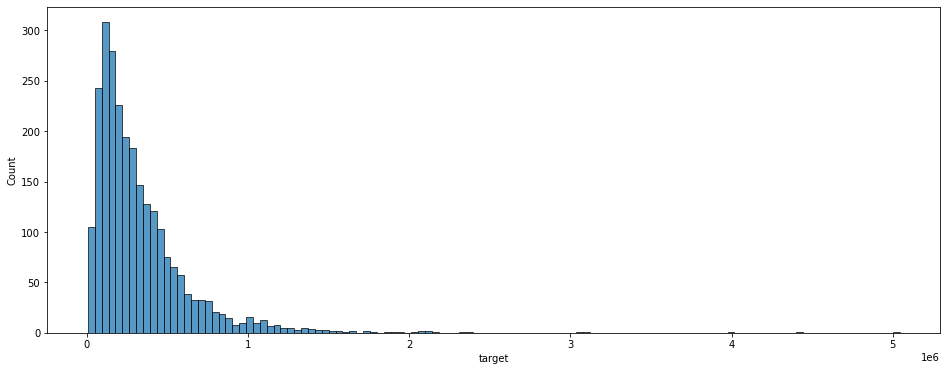

In [581]:
x = data[data.status.str.contains('auction')]
fig, ax = plt.subplots(figsize=(16, 6))
sns.histplot(x.target)

In [ ]:
x.target.min(), x.target.max()

In [27]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y=TARGET,
                data=data.loc[data.loc[:, column].isin(data.loc[:, column].value_counts().index)],
                ax=ax)
    ax.set_title('Boxplot for ' + column)
    plt.show()